In [1]:
import numpy as np
import numpy.random as npr
from scipy.stats import norm
import math
import matplotlib.pyplot as plt

In [2]:
import random
random.seed(10) #initialize the random state to always have the same results

# Useful functions 

## Densities

In [3]:
def normal_density(x, mean = 0, sd = 1):
  return (1/math.sqrt(2*math.pi*sd**2))*math.exp(-0.5*(x-mean)**2*sd**2)

def normal_density_vector(x, mean = 0, sd = 1):
    res = []
    for i in range (len(x)):
      res.append((1/math.sqrt(2*math.pi*sd**2))*math.exp(-0.5*(x[i]-mean)**2*sd**2))
    return (res)

from scipy.stats import multivariate_normal
def normal_density_vector_d(x, mean, sd):
   return(multivariate_normal.pdf(x, mean = mean, cov= sd))


## Resampling

In [4]:
def multinomial_resampling(w , x):
  u = npr.rand(*w.shape)
  bins = np.cumsum(w)
  indices = np.digitize(u, bins)
  indices = np.clip(indices, 0, len(x) - 1)
  return (x[indices], indices)

In [5]:
def multinomial_resampling_choose(w,x,num_samples=1):
    u = npr.rand(num_samples)  
    bins = np.cumsum(w)
    indices = np.digitize(u, bins) 
    indices = np.clip(indices, 0, len(x) - 1)
    return (x[indices], indices)

In [6]:
def multinomial_resampling_d(vectors, weights, num_samples):
    # Normalize weights
    normalized_weights = weights / np.sum(weights)
    # Resample indices
    indices = np.random.choice(np.arange(len(vectors)), size=num_samples, p=normalized_weights)
    # Resampled vectors
    resampled_vectors = vectors[indices]
    return resampled_vectors.transpose()

In [7]:
def multinomial_resampling_d_indices(vectors, weights, num_samples):
    # Normalize weights
    normalized_weights = weights / np.sum(weights)
    # Resample indices
    indices = np.random.choice(np.arange(len(vectors)), size=num_samples, p=normalized_weights)
    # Resampled vectors
    resampled_vectors = vectors[indices]
    return (resampled_vectors.transpose(), indices)

## RMSE

In [8]:
def RMSE(sequence, true_values):
  return (np.sqrt(sum((sequence-true_values)**2)/len(sequence)))

In [9]:
def RMSE_by_coordinate(seq1, seq2):
  D = len(seq1.transpose())
  T = len(seq1)
  res = []
  for i in range (D):
    res.append(RMSE(np.array(seq1).transpose()[i][1:], np.array(seq2).transpose()[i][1:]))
  return(res)

In [10]:
def RMSE_compare(kalman_res, nested_res, bpf_res): #check the error at each time
    RMSE_nested = RMSE_by_coordinate(kalman_res, nested_res)
    RMSE_bpf = RMSE_by_coordinate(kalman_res, bpf_res)
    
    return (RMSE_nested, RMSE_bpf)
    

## Plot multiple graphs

In [11]:
def plot_multiple_graphs(sequence_of_data, labels): #data gathers what we want to plot
    number_of_elements = len(sequence_of_data)
    dimension = len(sequence_of_data[0])
    rows = (dimension + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(12, 6 * rows))
    fig.suptitle(f"Results in dimension {dimension}")

    for i, ax in enumerate(axes.flat):
        for k in range (number_of_elements):
            if i < dimension:
                ax.plot(sequence_of_data[k][i], label= labels[k])
                ax.set_title(f"Dimension {i+1}")
                ax.legend()
                ax.grid(True)
            else:
                ax.axis("off")

    plt.tight_layout()
    plt.show()

## Plot paths

In [12]:
def path(particle_to_track, particles, indices):
    T = len(particles)
    ancestor_index = indices[T-1][particle_to_track]
    ancestor_value = [particles[T-1][particle_to_track], particles[T-2][ancestor_index]]
    for i in range (2, T):
        ancestor_index = indices[T-i][ancestor_index]
        ancestor_value.append(particles[T-i-1][ancestor_index])
    return(ancestor_value)


In [13]:
def plot_paths(particles, indices):
    N = len(particles[0]) #number of particles
    T = len(particles)
    res = np.empty([N, T])
    abs = [i for i in range (T)]
    for k in range (N):
        res[k] = path(k, particles, indices)
    for i in range (N):
        plt.plot(abs, res[i][::-1], label = 'Particle {}'.format(i+1)) #add title and labels
    #plt.xticks(abs)
    plt.title('Particles paths')
    plt.xlabel('Time(t)')
    plt.ylabel('Values')
    plt.grid(True)
    #plt.legend()

## Generate data

In [14]:
#generate some data following a linear gaussian 
def generate(A, B, var_eps, var_delta, T, D):
    x0 = np.array([npr.normal(0,1) for i in range (D)])
    y0 = np.array([npr.normal(0,1) for i in range (D)])

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(np.dot(A, X[t-1]) + np.array(npr.multivariate_normal(np.zeros(D), var_eps)))
        Y.append(np.dot(B, X[t]) + np.array(npr.multivariate_normal(np.zeros(D), var_delta)))
    return(X,Y)

In [15]:
#generate a lower triangular matrix in any dimension
def lower_triang(dim, a, b, row_sum_constraint):
    lower_triangular = np.zeros((dim, dim))
    for i in range(dim):
        # Calculate the maximum number of non-zero coefficients allowed in the current row
        max_coefficients = min(i+1, dim)  
        row_coefficients = np.random.uniform(a, b, max_coefficients)  # Random coefficients in the specified range

        # Normalize the coefficients to satisfy the row sum constraint
        row_coefficients /= row_coefficients.sum() / row_sum_constraint

        # Set the coefficients in the lower triangular part of the matrix
        lower_triangular[i, :max_coefficients] = row_coefficients

    return lower_triangular

## Compute mean

In [16]:
def compute_mean(vector, matrix, dimension, D):
    res = 0
    for k in range (D):
        res = res + matrix[dimension][k]*vector[k]
    return (res)

## Create trees

In [17]:
def is_power_of_2(num):
    # Base case: If num is 1, then it's 2^0
    if num == 1:
        return True

    # Starting with 2^0, check if the number is divisible by powers of 2
    power_of_2 = 1
    while power_of_2 < num:
        power_of_2 *= 2
        if power_of_2 == num:
            return True

    return False

In [18]:
def nodes_and_depth(number_of_leaves):
    if is_power_of_2(number_of_leaves) == True:
        total_nodes = 2*number_of_leaves - 1
        depth = int(math.log2(number_of_leaves)) + 1
        nodes_per_floor = []
        for level in range(1, depth + 1):
            nodes_in_level = 2 ** (level - 1)
            nodes_per_floor.append(nodes_in_level)
        return(total_nodes, depth,nodes_per_floor)
    else:
        return ('Not a binary tree')    

In [19]:
def create_tree(depth, sequence):
    if depth == 1 or len(sequence)==1:
        return [[sequence[0]], [sequence[1]]]
    return [create_tree(depth - 1, sequence[0:int(len(sequence)/2)]), create_tree(depth - 1, sequence[int(len(sequence)/2):])]

In [20]:
def divide_in_binary_tree(sequence): 
    D = len(sequence)
    res = nodes_and_depth(D)
    tree = [sequence[0]]
    if res == 'Not a binary tree':
        return (res)
    else:
        total_nodes, depth, nodes_per_floor = res
        if depth>1:
            tree = create_tree(depth - 1, sequence)
            return (tree)
        else:
            return (tree)

In [21]:
def create_almost_binary_tree(arr):
    def construct_tree(values):
        if len(values) == 1:
            return [values[0]]
        mid = len(values) // 2
        left = construct_tree(values[:mid])
        right = construct_tree(values[mid:])
        
        # Combine children if the number of children is odd
        if len(left) == 1 and len(right) > 1:
            return [[left[0]], right[0], right[1]]
        
        if len(right) == 1 and len(left) > 1:
            return [left[0], left[1], [right[0]]]
        
        return [left, right]

    return construct_tree(arr)

# Implemented filters

## Dimension 1

### Linear Gaussian models

Kalman filter

In [22]:
# kalman filter
def kalman_1_d(a, b, Y, X, var_eps, var_delta):
  estimate_mu_x = [X[0]]
  estimate_sigma_x = [var_eps]
  res = [[estimate_mu_x[0], X[0]]]
  for t in range (1,len(Y)):
    estimate_mu_x.append(a*estimate_mu_x[t-1])
    estimate_sigma_x.append(a**2*estimate_sigma_x[t-1] + var_eps)
    estimate_mu_x[t] = estimate_mu_x[t] + estimate_sigma_x[t]*b*(Y[t]-b*estimate_mu_x[t-1])/(b**2*estimate_sigma_x[t] + var_delta)
    estimate_sigma_x[t] = estimate_sigma_x[t] - estimate_sigma_x[t]**2*b**2/(b**2*estimate_sigma_x[t] + var_delta)
    res.append([estimate_mu_x[t], X[t]])
  return(res, estimate_mu_x, estimate_sigma_x)

Bootstrap particle filter

In [23]:
#implement the bootstrap filter
def step(x_previous, weights_previous, Y_observed, a, var_eps, var_delta, b):
  #resample
  test = multinomial_resampling(weights_previous, x_previous)
  resample = test[0] #multinomial resampling of the particles
  indices = test[1]
  #propagate
  x = np.array(npr.normal(a*resample,var_eps**2)) #sampling
  #compute weights
  w = np.empty(len(x))
  for i in range (len(x)):
    w[i] = np.array(normal_density(Y_observed, mean = b*x[i], sd = var_delta**2))
  return (x, w, sum(w*x)/sum(w), indices)

def bootstrap_filter(x, w, Y, a, var_eps, var_delta,b):
  N = len(x[0])
  estimate = [np.mean(x[0])]
  res = []
  indices = [[i for i in range (N)]]
  ESS = []
  for t in range (1,len(Y)):
      res = step(x[t-1], w[t-1], Y[t], a, var_eps, var_delta,b)
      x[t] = np.array(res[0])
      w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
      indices.append(res[3])
      #estimate
      estimate.append(res[2])
      ESS.append(1/(np.sum(w[t]**2)))
  return(x,w,estimate, indices, ESS)


Adaptive Bootstrap particle filter

In [24]:
def step_ess(x_previous, weights_previous, Y_observed, a, var_eps, var_delta, b, ESS_t, indices_t):
  N = len(x_previous)
  w = np.empty(len(x_previous))
  #resample
  if ESS_t <= N/2:
    test = multinomial_resampling(weights_previous, x_previous)
    resample = test[0] #multinomial resampling of the particles
    indices = test[1]
    #propagate
    x = np.array(npr.normal(a*resample,var_eps**2)) #sampling
    #compute weights
    for i in range (len(x)):
      w[i] = np.array(normal_density(Y_observed, mean = b*x[i], sd = var_delta**2))
  else :
    resample = x_previous
    indices = indices_t
    #propagate
    x = np.array(npr.normal(a*resample,var_eps**2)) #sampling
    #compute weights
    for i in range (len(x)):
      w[i] = np.array(normal_density(Y_observed, mean = b*x[i], sd = var_delta**2))*np.array(weights_previous[i])*N
  
  return (x, w, sum(w*x)/sum(w), indices)

def bpf_ess(x, w, Y, a, var_eps, var_delta,b):
  N = len(x[0])
  estimate = [np.mean(x[0])]
  res = []
  indices = [np.array([i for i in range (N)])]
  ESS = [0]
  for t in range (1,len(Y)):
      res = step_ess(x[t-1], w[t-1], Y[t], a, var_eps, var_delta,b, ESS[t-1], indices[t-1])
      x[t] = np.array(res[0])
      w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
      indices.append(res[3])
      #estimate
      estimate.append(res[2])
      ESS.append(1/(np.sum(w[t]**2)))
  return(x,w,estimate, indices, ESS)


## Dimension D>1

### Linear gaussian models

#### Kalman filter

In [25]:
#kalman filter
def kalman_filter_d(A, C, Q, R, true_Y, T, X0):
  mu_x = [X0]
  sigma_x = [Q]
  for t in range (1, T):
    #prediction
    mu_x = np.vstack([mu_x, (np.dot(A, mu_x[t-1]))])
    sigma_x = np.append(sigma_x, np.array([np.dot(np.dot(A, sigma_x[t-1]),A.transpose()) + Q]), axis= 0)
    #measurement update
    K = np.linalg.inv(np.array(np.dot(np.dot(C, sigma_x[t]), C.transpose()) + R))
    mu_x[t] = mu_x[t] + np.dot(np.dot(np.dot(sigma_x[t], C.transpose()), K), (true_Y[t] - np.dot(C, mu_x[t])))
    sigma_x[t] = sigma_x[t] - np.dot(np.dot(np.dot(np.dot(sigma_x[t], C.transpose()), K), C), sigma_x[t])
  return (mu_x, sigma_x)

#### Bootstrap particle filter

In [26]:
#implement the bootstrap filter in high dimension
def step_d(x_previous, weights_previous, Y_observed, A, var_eps, var_delta, D, N,B):
  #resample 
  res = multinomial_resampling_d_indices(x_previous.transpose(),weights_previous, num_samples = N) #multinomial resampling of the particles
  resample = res[0]
  indices = res[1]

  #propagate #sample xt^i from p(xt | xt-1^i_resampled)
  x = np.empty([D,N])
  for i in range(N):
    x[:,i] = np.array(np.dot(A, resample[:,i]) + npr.multivariate_normal(np.zeros(D), var_eps)) #creates an array for each i of dimension d
  
  #compute weights #p(yt|xt^i)
  w = np.empty(N)
  for i in range(N):
    w[i] = np.array(normal_density_vector_d(Y_observed, mean = np.dot(B,x[:,i]), sd = var_delta))
  w_norm = w/sum(w)

  #estimate
  estimate = np.array([0 for i in range (D)])
  for i in range(N):
    estimate = estimate + np.array(w_norm[i]*x[:,i])
  return (x, w_norm, estimate, indices)

def bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, N,B):
  D = len(Y[0])
  T = len(Y)
  x = np.array([np.empty([D,N]) for i in range (T)])
  w = np.empty([T,N])
  indices = np.empty([T,N])
  x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() 
  w[0] = np.array([[1/N for i in range (N)]])
  indices = [np.array([i for i in range (N)])]

  estimate = [np.zeros(D)] 
  res = []
  for t in range (1,T):
    res = step_d(x[t-1], w[t-1], Y[t], A, var_eps, var_delta, D, N,B)
    x[t] = np.array(res[0])
    w[t] = np.array(res[1]) #normalized weights
    estimate.append(res[2])
    indices.append(np.array(res[3]))
  return(x,w,estimate, indices)


#### Adaptive BPF

In [27]:
def step_d_ess(x_previous, weights_previous, Y_observed, A, var_eps, var_delta, D, N,B, ESS_t, indices_t): 
  w = np.empty(N)

  #resample
  if ESS_t <= N/2:
    res = multinomial_resampling_d_indices(x_previous.transpose(),weights_previous, num_samples = N)
    resample = res[0] #multinomial resampling of the particles
    indices = res[1]
    #propagate
    x = np.empty([D,N])
    for i in range(N):
      x[:,i] = np.array(np.dot(A, resample[:,i]) + npr.multivariate_normal(np.zeros(D), var_eps)) 
    #compute weights #p(yt|xt^i)
    w = np.empty(N)
    for i in range(N):
      w[i] = np.array(normal_density_vector_d(Y_observed, mean = np.dot(B,x[:,i]), sd = var_delta))
    w_norm = w/sum(w)
    #estimate
    estimate = np.array([0 for i in range (D)])
    for i in range(N):
      estimate = estimate + np.array(w_norm[i]*x[:,i]) 

  else : 
    resample = x_previous
    indices = indices_t
    #propagate
    x = np.empty([D,N])
    for i in range(N):
      x[:,i] = np.array(np.dot(A, resample[:,i]) + npr.multivariate_normal(np.zeros(D), var_eps)) 
    #compute weights
    w = np.empty(N)
    for i in range(N):
      w[i] = np.array(normal_density_vector_d(Y_observed, mean = np.dot(B,x[:,i]), sd = var_delta))
    w_norm = w/sum(w)
    #estimate
    estimate = np.array([0 for i in range (D)])
    for i in range(N):
      estimate = estimate + np.array(w_norm[i]*x[:,i]) #colonne de 3 ok
  return (x, w, estimate, indices)


def bpf_d_ess(Y, A, var_eps, var_delta,B,N):
  D = len(Y[0])
  T = len(Y)
  x = np.array([np.empty([D,N]) for i in range (T)])
  w = np.empty([T,N])
  x[0] = np.array([npr.multivariate_normal(np.zeros(D), np.identity(D)) for i in range (N)]).transpose() 
  w[0] = np.array([[1/N for i in range (N)]])
  
  estimate = [np.zeros(D)]
  res = []
  indices = [np.array([i for i in range (N)])]
  ESS = [0]
  for t in range (1,len(Y)):
      res = step_d_ess(x[t-1], w[t-1], Y[t], A, var_eps, var_delta,D,N, B, ESS[t-1], indices[t-1])
      x[t] = np.array(res[0])
      w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
      indices.append(res[3])
      #estimate
      estimate.append(res[2])
      ESS.append(1/(np.sum(w[t]**2)))
  return(x,w,estimate, indices, ESS)


#### Fully adapted PF

In [28]:
def kalman_filter_fapf_step(mu_x, sigma_x, A, C, Q, R, true_Y):
    #prediction
    mu_x_ = np.dot(A, mu_x)
    Pt_x_ = np.array(np.dot(np.dot(A, sigma_x),A.transpose()) + Q)
    #measurement update
    K = np.linalg.inv(np.array(np.dot(np.dot(C, sigma_x), C.transpose()) + R))
    mu_x_new = mu_x_ + np.dot(np.dot(np.dot(Pt_x_, C.transpose()), K), (true_Y - np.dot(C, mu_x_)))
    Pt_x_new = Pt_x_ - np.dot(np.dot(np.dot(np.dot(Pt_x_, C.transpose()), K), C), Pt_x_)
    return (mu_x_new, Pt_x_new)


def p_ycurr_xcurr(y_current, x_current, B, R): 
    return([multivariate_normal.pdf(y_current, mean = np.dot(B, x_current[i]), cov= R) for i in range (len(x_current))])

def p_ycurr_xprev(y_current, x_previous, B, R, A, Q):
    return([multivariate_normal.pdf(y_current, mean = np.dot(B,np.dot(A, x_previous[i])), cov = np.dot(np.dot(B, Q), B.transpose()) + R) for i in range (len(x_previous))])

def p_xcurr_xprev(x_current, x_previous,A,Q):
    return([multivariate_normal.pdf(x_current[i], mean = np.dot(A, x_previous[i]) , cov = Q) for i in range (len(x_current))])

def q_xcurr_xprev_ycurr(x_current, x_previous, y_curr, A, B, Q, R, sigma_previous):
    values = []
    res = []
    for i in range (len(x_previous)):
        values = kalman_filter_fapf_step(x_previous[i], sigma_previous, A, B, Q, R, y_curr) #i do the kalman filter for each which gives me the new x and cov matrix
        res.append(multivariate_normal.pdf(x_current[i], mean = values[0], cov = values[1]))
    return(np.array(res))

def q_xcurr_xprev_ycurr_init(x_current, x_previous, y_curr, A, B, Q, R, sigma_previous):
    values = kalman_filter_fapf_step(x_previous, sigma_previous, A, B, Q, R, y_curr)
    return(np.array([multivariate_normal.pdf(x_current[i], mean = values[0], cov = values[1]) for i in range (len(x_current))]))

def w_function(p_yc_xc, p_yc_xp, p_xc_xp, q_xc_xp_yc):
    return(p_yc_xc*p_xc_xp/(p_yc_xp*q_xc_xp_yc)) 



def fully_adapted(x_0, D, T, true_Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, Q, R, N): #on donne x et y les valeurs à t=0, N nombre de particules qu'on veut
  #initialization
  #D = np.shape(A)[0]
  #T = len(true_Y)
  estimate = np.empty([T,D])
  x = np.empty([T, N, D])
  kalman_res = kalman_filter_fapf_step(x_0, np.identity(D), A, B, Q, R, true_Y[0])
  kalman_res_mean = np.array([kalman_res[0]])
  kalman_res_cov = np.array([kalman_res[1]])
  x[0] = np.array([npr.multivariate_normal(kalman_res_mean[0], kalman_res_cov[0], N)])
  w = np.empty([T, N])
  w[0] = np.array([p_ycurr_xcurr(true_Y[0], x[0], B, R)/np.array(q_xcurr_xprev_ycurr_init(x[0], x_0, true_Y[0], A, B, Q, R, np.identity(D)))])
  w[0] = w[0]/sum(w[0]) #normalize weights
  nu = np.empty([T, N]) #adjustment multipliers
  estimate[0] = x_0

  #for loop
  for t in range (1, T):
    #adjustement multipliers
    nu[t-1] = np.array(p_ycurr_xprev(true_Y[t], x[t-1], B, R, A, Q))

    #resample
    weights = [nu[t-1][i]*w[t-1][i] for i in range (N)] 
    weights = weights/sum(weights)
    resample = multinomial_resampling_d_indices(x[t-1], weights, N)[0].transpose() 

    #propagate
    for i in range (len(resample)):
      kalman_res = kalman_filter_fapf_step(resample[i], np.identity(D), A, B, Q, R, true_Y[t])
      x[t][i] = npr.multivariate_normal(kalman_res[0], kalman_res[1],1) 

    #weight
    p_yc_xc = np.array(p_ycurr_xcurr(true_Y[t], x[t], B, R))
    p_yc_xp = np.array(p_ycurr_xprev(true_Y[t], x[t], B, R, A, Q))
    p_xc_xp = np.array(p_xcurr_xprev(x[t], x[t-1],A,Q))
    q_xc_xp_yc = np.array(q_xcurr_xprev_ycurr(x[t], x[t-1], true_Y[t], A, B, Q, R, np.identity(D)))
    w[t] = w_function(p_yc_xc, p_yc_xp, p_xc_xp, q_xc_xp_yc) 
    w[t] = w[t]/sum(w[t])
    
    #estimate the value
    estimate[t] = np.dot(w[t], x[t])

  return(x,w,estimate)
   

#### Divide and Conquer

In [29]:
def flatten_nested_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_nested_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

In [30]:
def extract_matrix(matrix, indices):
    res = np.empty((len(indices),len(indices)))
    for i in range (len(indices)):
        for j in range (len(indices)):
            res[i][j] = matrix[indices[i]][indices[j]]

    return(res)


In [31]:
def extract_matrix_2(matrix, list_indices): #good
    #print(matrix)
    indices_long = list_indices[0]
    for i in range (1, len(list_indices)):
        indices_long = np.concatenate((indices_long, list_indices[i]))
    res = np.empty((len(indices_long), len(indices_long)))
    for i in range (len(indices_long)):
        for j in range (len(indices_long)):
            res[i][j] = matrix[indices_long[i]][indices_long[j]]
    return(res)


In [32]:
def dac_smc_0_all(Y,A,B,var_eps, var_delta, N, tree): #initialization
    D = len(Y) #dimension
    particles = npr.normal(0,1,N)
    weights = np.abs(npr.normal(0,1,N))
    weigths = weights/sum(weights)
    new_tree_0 = tree
    new_tree_1 = tree 
    last_length = len(new_tree_0)
    estimate = 0
    if last_length == 1: #if we have a leaf
        particles = npr.normal(0,1,N)
        weights = [1/N for i in range (N)] 
        estimate = np.sum(particles*weights)/np.sum(weights)
        return(np.array(particles), np.array(weights/sum(np.array(weights))), estimate)
    if last_length == 2:
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        particles_0, weights_0,estimate_0 = dac_smc_0_all(Y, A, B, var_eps, var_delta, N, new_tree_0)
        particles_1, weights_1,estimate_1 = dac_smc_0_all(Y, A, B, var_eps, var_delta, N, new_tree_1) 
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node
        
        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1)) #the estimate when we concatenate
        else :
            estimate = np.array([estimate_0, estimate_1])
        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = [np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i])) for i in range (len(particles_0.transpose()))]
            d0 = len(particles_0)
            d1 = len(particles_1)
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i], np.zeros(d0), np.identity(d0))*normal_density_vector_d(particles_1.transpose()[i], np.zeros(d1), np.identity(d1)) for i in range (N)])
        else :
            particles = [[particles_0.transpose()[i], particles_1.transpose()[i]] for i in range(len(particles_0.transpose()))]
            denom = np.array([normal_density(particles_0[i], 0, 1)*normal_density(particles_1[i], 0, 1) for i in range (N)])
        d = len(particles[0])
        num = np.array([normal_density_vector_d(particles[i], np.zeros(d), np.identity(d)) for i in range (len(particles))])
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights), N)[0]
        weights = [1/N for i in range (N)]
        return (particles, weights, estimate)
    else :
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        new_tree_2 = tree[2] #child 3
        particles_0, weights_0,estimate_0 = dac_smc_0_all(Y, A, B, var_eps, var_delta, N, new_tree_0)
        particles_1, weights_1,estimate_1 = dac_smc_0_all(Y, A, B, var_eps, var_delta, N, new_tree_1) 
        particles_2, weights_2,estimate_2 = dac_smc_0_all(Y, A, B, var_eps, var_delta, N, new_tree_2) 
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node

        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1, estimate_2)) #the estimate when we concatenate
        else :
            estimate = np.array([estimate_0, estimate_1, estimate_2])
        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = [np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i])) for i in range (len(particles_0.transpose()))]
            d = len(particles_0)
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i], np.zeros(d), np.identity(d))*normal_density_vector_d(particles_1.transpose()[i], np.zeros(d), np.identity(d))*normal_density_vector_d(particles_2.transpose()[i], np.zeros(d), np.identity(d)) for i in range (N)])
        else :
            particles = [[particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i]] for i in range(len(particles_0.transpose()))]
            denom = np.array([normal_density(particles_0[i], 0, 1)*normal_density(particles_1[i], 0, 1)*normal_density(particles_2[i], 0, 1) for i in range (N)])
        d = len(particles[0])
        num = np.array([normal_density_vector_d(particles[i], np.zeros(d), np.identity(d)) for i in range (len(particles))])
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*weights_2[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights)/np.sum(weights), N)[0]
        weights = [1/N for i in range (N)]
        return (particles, weights, estimate)
    

In [33]:
def dac_step_all(old_particles, Y_t,A,B,var_eps, var_delta, N, tree):
    D = len(Y_t) #dimension
    particles = npr.normal(0,1,N)
    weights = np.abs(npr.normal(0,1,N))
    weigths = weights/sum(weights)
    new_tree_0 = tree
    new_tree_1 = tree
    last_length = len(new_tree_0)
    estimate = 0
    if last_length == 1: #if we have a leaf
        #modification : on sample de ftu
        u = np.where(np.array(Y_t) == tree[0])[0][0] #ok dit sur quelle dimension on travaille 
        #print(u)
        particles = np.array([npr.normal(A[u][u]*np.mean(old_particles, axis = 0)[u], var_eps[u][u]) for i in range (N)])
        weights = np.array([normal_density(Y_t[u], B[u][u]*particles[i], var_delta[u][u]) for i in range (len(particles))]) #pour l'isntant on part de matrices diagonales, on verra après comment changer 
        estimate = np.sum(particles*weights)/np.sum(weights)
        return(np.array(particles), np.array(weights/sum(np.array(weights))), estimate)
    if last_length == 2:
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        particles_0, weights_0,estimate_0 = dac_step_all(old_particles, Y_t, A, B, var_eps, var_delta, N, new_tree_0)
        particles_1, weights_1,estimate_1 = dac_step_all(old_particles, Y_t, A, B, var_eps, var_delta, N, new_tree_1) 
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node
    

        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1)) #the estimate when we concatenate
        else :
            estimate = np.array([estimate_0, estimate_1])

        #indices
        flatten_tree_0 = flatten_nested_list(new_tree_0)
        flatten_tree_1 = flatten_nested_list(new_tree_1)
        indices_0 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_0)[i])[0][0] for i in range (len(flatten_tree_0))])
        indices_1 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_1)[i])[0][0] for i in range (len(flatten_tree_1))])

        if len(indices_0) == 1: 
            indices_0 = indices_0[0]
        if len(indices_1) == 1:
            indices_1 = indices_1[0]

        u0 = indices_0
        u1 = indices_1


        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = np.array([np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i])) for i in range (len(particles_0.transpose()))])
            
            extract_0 = extract_matrix(A, u0)
            m0 = np.mean(particles_0.transpose(), axis = 0)
            dot_0 = np.dot(extract_0, m0)

            extract_1 = extract_matrix(A,u1)
            m1 = np.mean(particles_1.transpose(), axis = 0)
            dot_1 = np.dot(extract_1, m1)
            
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i],
                                                       dot_0, 
                                                       extract_matrix(var_eps, u0))*normal_density_vector_d(particles_1.transpose()[i], 
                                                                                                            dot_1, 
                                                                                                            extract_matrix(var_eps, u1)) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], 
                                                    np.concatenate((dot_0, dot_1)), 
                                                    extract_matrix_2(var_eps, np.array([u0, u1]))) for i in range (len(particles))])
        
        else :
            particles = np.array([[particles_0.transpose()[i], particles_1.transpose()[i]] for i in range(len(particles_0.transpose()))])
            denom = np.array([normal_density(particles_0[i], 0, 1)*normal_density(particles_1[i], 0, 1) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], 
                                                    np.array([A[u0][u0]*np.mean(particles_0.transpose(), axis = 0), A[u1][u1]*np.mean(particles_1.transpose(), axis = 0)]), 
                                                                            var_eps[u0][u0]*np.identity(len(particles[i]))) for i in range (len(particles))])
        
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights)/np.sum(weights), N)[0]
        weights = [1/N for i in range (N)]

        return (particles, weights, estimate)
    else : #si on en a 3
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        new_tree_2 = tree[2] #child 3
        particles_0, weights_0,estimate_0 = dac_step_all(old_particles, Y_t, A, B, var_eps, var_delta, N, new_tree_0)
        particles_1, weights_1,estimate_1 = dac_step_all(old_particles, Y_t, A, B, var_eps, var_delta, N, new_tree_1)
        particles_2, weights_2,estimate_2 = dac_step_all(old_particles, Y_t, A, B, var_eps, var_delta, N, new_tree_2) 
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node
      

        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1, estimate_2)) #the estimate when we concatenate
        else :
            estimate = np.array([estimate_0, estimate_1, estimate_2])

        flatten_tree_0 = flatten_nested_list(new_tree_0)
        flatten_tree_1 = flatten_nested_list(new_tree_1)
        flatten_tree_2 = flatten_nested_list(new_tree_2)
        indices_0 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_0)[i])[0][0] for i in range (len(flatten_tree_0))])
        indices_1 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_1)[i])[0][0] for i in range (len(flatten_tree_1))])
        indices_2 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_2)[i])[0][0] for i in range (len(flatten_tree_2))])

        if len(indices_0) == 1: 
            indices_0 = indices_0[0]
        if len(indices_1) == 1:
            indices_1 = indices_1[0]
        if len(indices_2) == 1:
            indices_2 = indices_2[0]

        u0 = indices_0
        u1 = indices_1
        u2 = indices_2

        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = np.array([np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i])) for i in range (len(particles_0.transpose()))])
            
            extract_0 = extract_matrix(A, u0)
            m0 = np.mean(particles_0.transpose(), axis = 0)
            dot_0 = np.dot(extract_0, m0)

            extract_1 = extract_matrix(A,u1)
            m1 = np.mean(particles_1.transpose(), axis = 0)
            dot_1 = np.dot(extract_1, m1)

            extract_2 = extract_matrix(A, u2)
            m2 = np.mean(particles_2.transpose(), axis = 0)
            dot_2 = np.dot(extract_2, m2)
            
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i], dot_0, 
                                                      extract_matrix(var_eps, u0))
                                                      *normal_density_vector_d(particles_1.transpose()[i], dot_1, 
                                                                               extract_matrix(var_eps, u1))
                                                                               *normal_density_vector_d(particles_2.transpose()[i], dot_2, 
                                                                                                        extract_matrix(var_eps, u2)) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], np.concatenate((dot_0, dot_1, dot_2)), extract_matrix_2(var_eps, np.array([u0, u1, u2]))) for i in range (len(particles))]) #changer la variance à réfléchir
        else :
            particles = np.array([[particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i]] for i in range(len(particles_0.transpose()))])
            d = len(particles[0])
            denom = np.array([normal_density(particles_0[i], 0, 1)*normal_density(particles_1[i], 0, 1)*normal_density(particles_2[i], 0, 1) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], np.array([A[u0][u0]*np.mean(particles_0.transpose(), axis = 0), A[u1][u1]*np.mean(particles_1.transpose(), axis = 0), A[u2][u2]*np.mean(particles_2.transpose(), axis = 0)]), var_eps[u0][u0]*np.identity(len(particles[i]))) for i in range (len(particles))])
        
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*weights_2[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights)/np.sum(weights), N)[0]
        weights = [1/N for i in range (N)]
        return (particles, weights, estimate)
    

In [34]:
def dac_procedure_all(Y,A,B,var_eps, var_delta, N):
    T = len(Y)
    D = len(Y[0])
    tree = create_almost_binary_tree(Y[0])
    estimate = np.empty([T,D])
    particles = np.empty([T,D,N])
    weights = np.empty([T,N])
    res = dac_smc_0_all(Y[0],A,B,var_eps, var_delta, N, tree) #au rang 0
    particles[0] = res[0]
    weights[0] = res[1]
    estimate[0] = res[2]

    old_particles = particles[0].transpose()
    for t in range (1,T):
        #print(t)
        tree = create_almost_binary_tree(Y[t]) #on crée l'arbre
        res = dac_step_all(old_particles, Y[t],A,B,var_eps, var_delta,N,tree)
        #print(np.shape(particles[0]), np.shape(res[0]))
        particles[t] = res[0]
        weights[t] = res[1]
        estimate[t] = res[2]

        old_particles = particles[t].transpose()
    
    return(particles, weights, estimate)


#### Nested SMC

##### Forward filter in the space

In [35]:
def compute_mean(vector, matrix, dimension, D):
    res = 0
    for k in range (D):
        res = res + matrix[dimension][k]*vector[k]
    return (res)

In [36]:
def forward_filter_step_lg(selected_outer_part, prev_estimate, M, A, var_eps, D, Y, B, var_delta):
    #initialize
    inner_particles = np.empty([M,D])
    inner_weights = np.empty([M,D])
    outer = np.empty(D)

    #run a SMC in the state
    #no need to resample since independence in the components, we sample the state vector and compute the weights

    #sample a new vector 
    for i in range (M):
        inner_particles[i] = npr.multivariate_normal(np.dot(A,prev_estimate), np.array(var_eps))

    #weights
    for j in range (M):
        #0
        p_1 = normal_density(inner_particles[j][0], np.dot(A, selected_outer_part)[0], var_eps[0][0])*normal_density_vector_d(Y[0], B[0][0]*inner_particles[j][0], var_delta[0][0])
        r_1 = normal_density(inner_particles[j][0], np.dot(A, prev_estimate)[0], var_eps[0][0])
        inner_weights[j][0] = p_1/r_1
        for d in range (1,D): 
            p_d = normal_density_vector_d(inner_particles[j][0:d], np.dot(A, selected_outer_part)[0:d], var_eps[0:d,0:d])*normal_density_vector_d(Y[0:d], np.dot(B[0:d, 0:d], inner_particles[j][0:d]), var_delta[0:d, 0:d])
            if d>1:
                p_d_1 = normal_density_vector_d(inner_particles[j][0:d-1], np.dot(A, selected_outer_part)[0:d-1], var_eps[0:d-1,0:d-1])*normal_density_vector_d(Y[0:d-1], np.dot(B[0:d-1, 0:d-1], inner_particles[j][0:d-1]), var_delta[0:d-1, 0:d-1])
            else:
                p_d_1 = normal_density(inner_particles[j][0], np.dot(A, selected_outer_part)[0], var_eps[0][0])*normal_density(Y[0], B[0][0]*inner_particles[j][0], var_delta[0][0])
            r_d = normal_density(inner_particles[j][d], np.dot(A, prev_estimate)[d], var_eps[d][d])
            #print('p_d', p_d, 'p_d_1', p_d_1, 'r_d', r_d) 
            
            inner_weights[j][d] = p_d/(p_d_1*r_d)

    #normalize weights
    for d in range (D):
        s = np.sum(inner_weights.transpose()[d])
        for i in range (M):
            inner_weights.transpose()[d][i] = inner_weights.transpose()[d][i]/s
        
    #compute estimate
    for d in range (D):
        outer[d] = np.sum(inner_weights.transpose()[d]*inner_particles.transpose()[d])
    return (inner_particles, inner_weights, outer)


In [37]:
def forward_filter(outer_particles, prev_estimate, M, A, var_eps, D, Y, B, var_delta):
    N = len(outer_particles)
    inner_particles = np.empty([N, M, D]) 
    inner_weights = np.empty([N, M, D]) 
    outer_particles = np.empty([N,D])
    outer_particles_weights = np.empty(N)
   
    s = 0 

    for i in range (N):
        res = forward_filter_step_lg(outer_particles[i], prev_estimate, M, A, var_eps, D, Y, B, var_delta)
        inner_particles[i] = res[0]
        inner_weights[i] = res[1]
        outer_particles[i] = res[2]
        outer_particles_weights[i] = np.prod(np.sum(inner_weights[i], axis = 1))
        s = s + outer_particles_weights[i]
    outer_particles_weights = outer_particles_weights/s
    
    estimate_outer = np.sum(np.array([outer_particles_weights[i]*outer_particles[i] for i in range (N)]),axis = 0)
    return (inner_particles, inner_weights, outer_particles, outer_particles_weights, estimate_outer, prev_estimate)


##### Backward propagation 

In [38]:
def backward_propagation(particles, weights, A, estimate, var_eps, Y, B, var_delta): 
    d = len(particles) 
    num_internal_particles = len(particles[0])  
    sampled_data = [None] * d
    b_nx = multinomial_resampling_choose(weights[d-1], particles[d-1])[1][0] #best particle for that dimension 
    sampled_data[d-1] = particles[d-1][b_nx]

    for i in range(d - 1, 0, -1):
        new_weights = np.zeros(num_internal_particles)
        mean_num = estimate 
        mean_denom = estimate[0:i] 
        sd_num = var_eps
        sd_denom = var_eps[0:i,0:i]
        for j in range(num_internal_particles):
            #reweight for particle j
            concat = np.concatenate((np.array(particles[0:i].transpose()[j]), np.array(sampled_data[i:])) , axis = 0)             
            mean_num_ = np.dot(B, concat)
            new_set = particles[0:i].transpose()[j]
            mean_denom_ = np.dot(B[0:i,0:i], new_set)
            num = normal_density_vector_d(concat, mean = mean_num, sd = sd_num)*normal_density_vector_d(Y, mean_num_, var_delta)
            denom = normal_density_vector_d(new_set, mean = mean_denom, sd = sd_denom)*normal_density_vector_d(Y[0:i], mean_denom_, var_delta[0:i, 0:i])
            if denom !=0:
                reweight_factor = num / denom
            else :
                reweight_factor = 1
            new_weights[j] = weights[i][j] * reweight_factor 
        new_weights /= np.sum(new_weights)
        b_d = multinomial_resampling_choose(new_weights, particles[d-1])[1][0]
        sampled_data[i-1] = particles[i-1][b_d]
    

    return sampled_data


##### Nested smc algorithm

In [39]:
def nested_smc_new(N, M, A, B, var_delta, var_eps, Y, D, T):
    outer_particles = np.empty([T,N,D])
    outer_particles_estimate = np.empty([T,D])
    outer_particles_weights = np.empty([T,N])
    estimate_outer = np.empty([T, D])

    inner_particles = np.empty([T, N, M, D])
    inner_particles_weights = np.empty([T, N, M, D])

    new_inner_particles = np.empty([T, N, M, D])
    new_inner_particles_weights = np.empty([T, N, M, D])

    outer_particles[0] = npr.normal(0,var_eps[0][0],([N,D]))
    for i in range (N):
        outer_particles_weights[0][i] = normal_density_vector_d(Y[0], outer_particles[0][i], var_delta)
    s = np.sum(outer_particles_weights[0])
    outer_particles_weights[0] = outer_particles_weights[0]/s
    estimate_outer[0] = np.sum([outer_particles_weights[0][i]*outer_particles[0][i] for i in range (N)], axis = 0)/np.sum(outer_particles_weights[0])

    prev_estimate = estimate_outer[0]

    for t in range (1,T):
        #print(t)
        #forward filter
        res_ff = forward_filter(outer_particles[t-1], prev_estimate, M, A, var_eps, D, Y[t], B, var_delta)
        inner_particles[t] = res_ff[0]
        inner_particles_weights[t] = res_ff[1]
        outer_particles[t] = np.array(res_ff[2])
        outer_particles_weights[t] = res_ff[3]
        estimate_outer[t] = res_ff[4]

        prev_estimate = res_ff[-1]

        #resampling : resample the inner state according to the weight that has the outer state 
        resample_res = multinomial_resampling_d_indices(outer_particles[t], outer_particles_weights[t], N)
        outer_particles[t] = resample_res[0].transpose()
        indices = resample_res[1]
        new_inner_particles[t] = inner_particles[t][indices]
        new_inner_particles_weights[t] = inner_particles_weights[t][indices]
        #normalize weights 
        for i in range (N):
            for d in range (D):
                s = np.sum(new_inner_particles_weights[t][i].transpose()[d])
                for m in range (M):
                    new_inner_particles_weights[t][i].transpose()[d][m] = new_inner_particles_weights[t][i].transpose()[d][m]/s

        #backward propagation
        for i in range (N):

            outer_particles[t][i] = backward_propagation(inner_particles[t][i].transpose(), new_inner_particles_weights[t][i].transpose(), A, estimate_outer[t], var_eps, Y[t], B, var_delta)
            outer_particles_weights[t][i] = normal_density_vector_d(Y[t], outer_particles[t][i], var_delta)
            
        s = np.sum(outer_particles_weights[t])
        outer_particles_weights[t] = outer_particles_weights[t]/s

        outer_particles_estimate[t] = np.sum([outer_particles_weights[t][i]*outer_particles[t][i] for i in range (N)], axis = 0)/np.sum(outer_particles_weights[t])

    return(outer_particles, outer_particles_estimate, outer_particles_weights)


### Lorenz model

#### Generate the model


$dX_{k}(t) = ((X_{k+1}(t) - X_{k-2}(t))X_{k-1}(t) - X_{k}(t) + F)dt + bdW_{k}(t)$

In [40]:
from scipy.integrate import odeint

In [41]:
def L96_no_noise(x, t, F):
    """Lorenz 96 model with constant forcing"""
    D = len(x)
    d = np.zeros(D)
    for i in range(D):
        d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def generate_lorenz_no_noise(F, D, T, dt):
    x0 = F * np.ones(D)  # Initial state (equilibrium)
    x0[0] += 0.01  # Add small perturbation to the first variable
    t = np.arange(0.0, T, dt)
    x = odeint(L96_no_noise, x0, t, args=(F,))
    return x

In [42]:
def L96_noise(x, t, F):
    """Lorenz 96 model with constant forcing"""
    D = len(x)
    d = np.zeros(D)
    for i in range(D):
        d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
    return d

def generate_lorenz_with_transition_noise(F, D, T, noise_strength, dt):
    x0 = F * np.ones(D) + npr.normal(0,noise_strength,D) # Initial state (equilibrium)
    x0[0] += noise_strength  # Add small perturbation to the first variable
    t = np.arange(0.0, T, dt)
    
    num_steps = len(t)
    x = np.zeros((num_steps, D))
    x[0] = x0
    
    for i in range(1, num_steps):
        dW = noise_strength * np.sqrt(dt) * np.random.randn(D)
        #dW = noise_strength * np.random.randn(D)
        dX = L96_noise(x[i - 1], t[i - 1], F) * dt
        x[i] = x[i - 1] + dX + dW
    
    return x

In [43]:
def generate_lorenz_with_transition_noise_x(x0, F, D, T, noise_strength, dt):
    t = np.arange(0.0, T, dt)
    
    num_steps = len(t)
    x = np.zeros((num_steps, D))
    x[0] = x0
    
    for i in range(1, num_steps):
        #dW = noise_strength * np.sqrt(dt) * np.random.randn(D)
        dW = noise_strength * np.random.randn(D)
        dX = L96_noise(x[i - 1], t[i - 1], F) * dt
        x[i] = x[i - 1] + dX + dW
    
    return x

In [44]:
def generate_lorenz_without_transition_noise_x(x0, F, D, T, dt):
    t = np.arange(0.0, T, dt)
    
    num_steps = len(t)
    x = np.zeros((num_steps, D))
    x[0] = x0
    
    for i in range(1, num_steps):
        dX = L96_no_noise(x[i - 1], t[i - 1], F) * dt
        x[i] = x[i - 1] + dX
    
    return x

#### EKF

In [45]:
def generate_full_jacobian(x):
    n = len(x)
    matrix = np.zeros((n, n))

    for i in range(n-2):
        matrix[i, i+1] = x[i+2]-x[i]  # Diagonal above
        matrix[i, i+2] = - x[i+2]
    for i in range (1, n):
        matrix[i, i-1] = x[i-1]  #below
    matrix[n-2,n-1] = x[1] - x[n-2]
    matrix[n-3, 0] = - x[n-2]
    matrix[n-2, 0] = x[1] - x[n-3]
    return np.matrix(matrix)

In [46]:
# extended kalman filter
def ekf_lorenz_0(initial_state, Y_obs, dt, T, noise_strength_x, noise_strength_y, F, D, generate_full_jacobian):
    mu_x = [initial_state]
    Q = noise_strength_x**2*np.identity(D)
    covariance = Q
    sigma_x = [Q]
    R = noise_strength_y**2*np.identity(D)
    state = np.array(initial_state)
    propagate = []
    for t in range (1,T): 
        # Prediction
        propagate = generate_lorenz_with_transition_noise_x(state, F, D, 1*dt, noise_strength_x, dt)[-1] #2.23c
        #print(propagate)
        state = propagate #x

        F = generate_full_jacobian(state)
        H = np.identity(D)
        predicted_covariance = np.dot(np.dot(F, covariance), F.T) + Q #2.23d
        
        # Update Step  
        #predicted measurement 
        predicted_measurement = state + npr.normal(0, noise_strength_y**2)

        kalman_gain = np.dot(np.dot(predicted_covariance, H.T),np.linalg.inv(np.dot(np.dot(H, predicted_covariance), H.T) + R)) #2.23e
        measurement = Y_obs[t]
        state = state + np.dot(kalman_gain, (measurement - predicted_measurement))  #2.23a
        state = np.array(np.array(state)[0])
        covariance = predicted_covariance - np.dot(np.dot(kalman_gain, H), predicted_covariance) #2.23b

        #keep it
        mu_x.append(state)
        sigma_x.append(covariance)

    return(mu_x, sigma_x)


#### BPF all states observed

In [47]:
def step_bpf_lorenz_x_y(x_previous, weights_previous, Y_observed, N, D, F,H, noise_strength_x, noise_strength_y, dt, time_step): 
    #resample
    res = multinomial_resampling_d_indices(x_previous.transpose(),weights_previous, num_samples = N) #multinomial resampling of the particles
    resample = res[0].transpose()
    #print(np.shape(resample))
    indices = res[1]
    x = np.empty([N, D])

    #propagate
    for i in range (N):
        x[i] = generate_lorenz_with_transition_noise_x(resample[i], F, D, time_step, noise_strength_x, dt)[-1]

    #weighting
    w = np.empty(N)
    for i in range (N): 
        w[i] = normal_density_vector_d(Y_observed, mean = np.dot(H,x[i]), sd = np.identity(D)*noise_strength_y**2) 
    w_norm = w/sum(w)

    #estimate   
    estimate = np.array([0 for i in range (D)])
    for i in range(N):
        estimate = estimate + np.array(w_norm[i]*x[i])
    return (x.transpose(),w_norm, estimate,indices)
    

def bpf_lorenz_x_y(Y, noise_strength_x, noise_strength_y, N, F, D, T, H, dt):
    #T = len(Y)
    x = np.empty([T,D,N])
    w = np.empty([T,N])
    indices = np.empty([T,N])
    x[0] = np.array([npr.multivariate_normal(np.zeros(D), F*np.identity(D)) for i in range (N)]).transpose()
    w[0] = np.array([[1/N for i in range (N)]])
    indices = [np.array([i for i in range (N)])]

    estimate = [np.zeros(D)] 
    res = []
    for t in range (1,T):
        res = step_bpf_lorenz_x_y(x[t-1], w[t-1], Y[t],N, D, F, H, noise_strength_x, noise_strength_y, dt, 1)
        x[t] = np.array(res[0])
        w[t] = np.array(res[1]) #normalized weights
        estimate.append(res[2])
        indices.append(np.array(res[3]))
    return(x,w,estimate, indices)

    

#### BPF half states observed

In [48]:
def step_bpf_lorenz_half_states(x_previous, weights_previous, Y_observed, N, D, F,H, noise_strength_x, noise_strength_y, dt, time_step, observed_indices): #var correspond à la variance de mesurement de y
    #resample
    res = multinomial_resampling_d_indices(x_previous.transpose(),weights_previous, num_samples = N) #multinomial resampling of the particles
    resample = res[0].transpose()
    indices = res[1]
    x = np.empty([N, D])

    #propagate
    for i in range (N):
        x[i] = generate_lorenz_with_transition_noise_x(resample[i], F, D, time_step, noise_strength_x, dt)[-1] 

    #weighting
    w = np.empty(N)
    d_y = len(observed_indices)
    for i in range (N): 
        w[i] = normal_density_vector_d(Y_observed, mean = np.dot(H,x[i])[observed_indices], sd = np.identity(d_y)*noise_strength_y**2) 
    w_norm = w/sum(w)

    #estimate   
    estimate = np.array([0 for i in range (D)])
    for i in range(N):
        estimate = estimate + np.array(w_norm[i]*x[i])
    return (x.transpose(),w_norm, estimate,indices)
    

def bpf_lorenz_half_states(Y, noise_strength_x, noise_strength_y, N, F, D, T, H, dt, observed_indices):
    #T = len(Y)
    x = np.empty([T,D,N])
    w = np.empty([T,N])
    indices = np.empty([T,N])
    x[0] = np.array([npr.multivariate_normal(np.zeros(D), F*np.identity(D)) for i in range (N)]).transpose()
    w[0] = np.array([[1/N for i in range (N)]])
    indices = [np.array([i for i in range (N)])]

    estimate = [np.zeros(D)]
    res = []
    for t in range (1,T):
        res = step_bpf_lorenz_half_states(x[t-1], w[t-1], Y[t],N, D, F, H, noise_strength_x, noise_strength_y, dt, 1, observed_indices)
        x[t] = np.array(res[0])
        w[t] = np.array(res[1]) #normalized weights
        estimate.append(res[2])
        indices.append(np.array(res[3]))
    return(x,w,estimate, indices)

    

#### FAPF

In [49]:
#kalman filter step for the fapf
def kalman_gain_compute(Q,H,R):
    return(np.dot(np.dot(Q,H.T), np.linalg.inv(np.dot(np.dot(H,Q),H.T) + R)))

In [50]:
def fapf_lorenz(x_0, true_y, Q, R, N, D, T, H, dt, F, noise_strength_x):
    estimate = np.empty([T,D])
    x = np.empty([T, N, D])
    kalman_gain = kalman_gain_compute(Q,H,R)
    cov = Q - np.dot(kalman_gain, np.dot(H,Q)) #update covariance
    x_pred = generate_lorenz_with_transition_noise_x(x_0, F, D, 1, noise_strength_x, dt)[-1]
    mean = x_pred  + np.dot(kalman_gain,(true_y[0] - np.dot(H,x_pred)))
    x[0] = np.array([npr.multivariate_normal(mean, cov, N)])
    w = np.empty([T, N])
    w[0] = np.array([1/N for i in range (N)])
    nu = np.empty([T, N]) #adjustment multipliers
    estimate[0] = x_0
    cov_X = cov
    x_pred = np.empty([N,D])
    for t in range (1, T):
        #print(t)
        #compute nu
        for i in range (N):
            x_pred[i] = generate_lorenz_with_transition_noise_x(x[t][i], F, D, 1, noise_strength_x, dt)[-1]
            nu[t][i] = normal_density_vector_d(true_y[t], np.dot(H, x_pred[i]), np.dot(np.dot(H,cov_X), H.T)+R)
        
        #resample 
        weights = [nu[t-1][i]*w[t-1][i] for i in range (N)] #nouveaux weights pour cette étape
        if min(weights)<= 10**(-50):
            weights = np.array([1/N for i in range(N)])
        weights = weights/sum(weights)
        resample = multinomial_resampling_d_indices(x[t-1], weights, N)[0].transpose()
        
        #propagate
        kalman_gain = kalman_gain_compute(cov_X,H,R) 
        cov_X = cov_X - np.dot(kalman_gain, np.dot(H,cov_X)) #update covariance
        for i in range (N):
            x_pred[i] = generate_lorenz_with_transition_noise_x(resample[i], F, D, 1, noise_strength_x, dt)[-1]
            mean = x_pred[i] + np.dot(kalman_gain,(true_y[t] - np.dot(H,x_pred[i])))
            x[t][i] = npr.multivariate_normal(mean, cov_X,1)

        w[t] = np.array([1/N for i in range (N)])

        estimate[t] = np.dot(w[t], x[t])
    
    return(x,w,estimate)


#### DAC

In [51]:
def dac_smc_0_lorenz(Y,F,H,noise_strength_x, N, tree): 
    D = len(Y) #dimension
    particles = npr.normal(F,noise_strength_x,N) 
    weights = [1/N for i in range (N)] 
    new_tree_0 = tree
    new_tree_1 = tree 
    last_length = len(new_tree_0)
    estimate = 0
    if last_length == 1: #if we have a leaf
        particles = npr.normal(F,noise_strength_x,N)
        weights = [1/N for i in range (N)]
        estimate = np.sum(particles*weights)/np.sum(weights)
        return(np.array(particles), np.array(weights/sum(np.array(weights))), estimate)
    if last_length == 2:
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        particles_0, weights_0,estimate_0 = dac_smc_0_lorenz(Y, F, H, noise_strength_x, N, new_tree_0)
        particles_1, weights_1,estimate_1 = dac_smc_0_lorenz(Y, F, H, noise_strength_x, N, new_tree_1) 
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node
        
        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1)) #the estimate when we concatenate
        else :
            estimate = np.array([estimate_0, estimate_1])
        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = [np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i])) for i in range (len(particles_0.transpose()))]
            d0 = len(particles_0)
            d1 = len(particles_1)
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i], F*np.ones(d0), noise_strength_x*np.identity(d0))*normal_density_vector_d(particles_1.transpose()[i], F*np.ones(d1), noise_strength_x*np.identity(d1)) for i in range (N)])
        else :
            particles = [[particles_0.transpose()[i], particles_1.transpose()[i]] for i in range(len(particles_0.transpose()))]
            denom = np.array([normal_density(particles_0[i], F,noise_strength_x )*normal_density(particles_1[i], F, noise_strength_x) for i in range (N)])
        d = len(particles[0])
        num = np.array([normal_density_vector_d(particles[i], F*np.ones(d), noise_strength_x*np.identity(d)) for i in range (len(particles))])
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights), N)[0]
        weights = [1/N for i in range (N)]
        return (particles, weights, estimate)
    else :
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        new_tree_2 = tree[2] #child 3
        particles_0, weights_0,estimate_0 = dac_smc_0_lorenz(Y, F, H, noise_strength_x, N, new_tree_0)
        particles_1, weights_1,estimate_1 = dac_smc_0_lorenz(Y, F, H, noise_strength_x, N, new_tree_1) 
        particles_2, weights_2,estimate_2 = dac_smc_0_lorenz(Y, F, H, noise_strength_x, N, new_tree_2) 
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node

        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1, estimate_2)) #the estimate when we concatenate
        else :
            estimate = np.array([estimate_0, estimate_1, estimate_2])
        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = [np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i])) for i in range (len(particles_0.transpose()))]
            d = len(particles_0)
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i], F*np.ones(d), noise_strength_x*np.identity(d))*normal_density_vector_d(particles_1.transpose()[i], F*np.ones(d), noise_strength_x*np.identity(d))*normal_density_vector_d(particles_2.transpose()[i], F*np.ones(d), noise_strength_x*np.identity(d)) for i in range (N)])
        else :
            particles = [[particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i]] for i in range(len(particles_0.transpose()))]
            denom = np.array([normal_density(particles_0[i], F, noise_strength_x)*normal_density(particles_1[i], F, noise_strength_x)*normal_density(particles_2[i], F, noise_strength_x) for i in range (N)])
        d = len(particles[0])
        num = np.array([normal_density_vector_d(particles[i], F*np.ones(d), noise_strength_x*np.identity(d)) for i in range (len(particles))])
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*weights_2[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights)/np.sum(weights), N)[0]
        weights = [1/N for i in range (N)]
        return (particles, weights, estimate)
    

In [52]:
def dac_step_Lorenz(old_particles,Y_t,N, tree,F,D, noise_strength_x, noise_strength_y, dt,H):
    new_tree_0 = tree
    new_tree_1 = tree
    last_length = len(new_tree_0)
    estimate = 0
    propagate = np.array([generate_lorenz_with_transition_noise_x(old_particles[i],F,D,1, noise_strength_x, dt)[-1] for i in range (len(old_particles))])
    if last_length == 1: #if we have a leaf
        particles = np.empty([N])
        u = np.where(np.array(Y_t) == tree[0])[0][0] 
        for i in range (N):
            particles[i] = npr.normal(propagate[i][u],  noise_strength_x, 1)
            #attention : on veut sample des particules donc on fait la fonction déterministe et ensuite on sample de la normale de moyenne f(x_{t-1}) et var noise_strength
        weights = np.array([normal_density(Y_t[u], H[u][u]*particles[i], noise_strength_y) for i in range(len(particles))]) 
        estimate = np.sum(particles*weights)/np.sum(weights)
        norm_weights = np.array(weights/sum(np.array(weights)))
        return(np.array(particles), norm_weights, estimate)
    
    if last_length == 2:
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        particles_0, weights_0,estimate_0 = dac_step_Lorenz(old_particles, Y_t, N, new_tree_0, F, D, noise_strength_x, noise_strength_y, dt, H)
        particles_1, weights_1,estimate_1 = dac_step_Lorenz(old_particles, Y_t, N, new_tree_1, F, D, noise_strength_x, noise_strength_y, dt, H)
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node

        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1)) #the estimate when we concatenate
            
        else :
            estimate = np.array([estimate_0, estimate_1])

        #indices
        flatten_tree_0 = flatten_nested_list(new_tree_0)
        flatten_tree_1 = flatten_nested_list(new_tree_1)
        indices_0 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_0)[i])[0][0] for i in range (len(flatten_tree_0))])
        indices_1 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_1)[i])[0][0] for i in range (len(flatten_tree_1))])

        if len(indices_0) == 1: 
            indices_0 = indices_0[0]
        if len(indices_1) == 1:
            indices_1 = indices_1[0]

        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = np.array([np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i])) for i in range (len(particles_0.transpose()))])
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i], np.mean(propagate.transpose()[indices_0].transpose(), axis = 0), noise_strength_x)*normal_density_vector_d(particles_1.transpose()[i], np.mean(propagate.transpose()[indices_1].transpose(), axis = 0), noise_strength_x) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], np.concatenate((np.mean(propagate.transpose()[indices_0].transpose(), axis = 0),np.mean(propagate.transpose()[indices_1].transpose(), axis = 0))) ,noise_strength_x*np.identity(len(particles[i])) )for i in range (len(particles))]) 
        else :
            particles = np.array([[particles_0.transpose()[i], particles_1.transpose()[i]] for i in range(len(particles_0.transpose()))])
            denom = np.array([normal_density(particles_0[i], np.mean(propagate.transpose()[indices_0],axis = 0), noise_strength_x)*normal_density(particles_1[i], np.mean(propagate.transpose()[indices_1],axis = 0), noise_strength_x) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], np.array([np.mean(propagate.transpose()[indices_0].transpose(), axis = 0), np.mean(propagate.transpose()[indices_1].transpose(), axis = 0)]), noise_strength_x*np.identity(len(particles[i]))) for i in range (len(particles))])
        
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights)/np.sum(weights), N)[0]
        weights = [1/N for i in range (N)]
        return (particles, weights, estimate)
    
    else : 
        #recursively go down the tree until we find a leaf
        new_tree_0 = tree[0] #child 1
        new_tree_1 = tree[1] #child 2
        new_tree_2 = tree[2] #child 3
        particles_0, weights_0,estimate_0 = dac_step_Lorenz(old_particles, Y_t, N, new_tree_0, F, D, noise_strength_x, noise_strength_y, dt, H)
        particles_1, weights_1,estimate_1 = dac_step_Lorenz(old_particles, Y_t, N, new_tree_1, F, D, noise_strength_x, noise_strength_y, dt, H)
        particles_2, weights_2,estimate_2 = dac_step_Lorenz(old_particles, Y_t, N, new_tree_2, F, D, noise_strength_x, noise_strength_y, dt, H) 
        last_length = len(new_tree_0) #indicator of if we have a leaf or a node

        flatten_tree_0 = flatten_nested_list(new_tree_0)
        flatten_tree_1 = flatten_nested_list(new_tree_1)
        flatten_tree_2 = flatten_nested_list(new_tree_2)
        indices_0 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_0)[i])[0][0] for i in range (len(flatten_tree_0))])
        indices_1 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_1)[i])[0][0] for i in range (len(flatten_tree_1))])
        indices_2 = np.array([np.where(np.array(Y_t) == np.array(flatten_tree_2)[i])[0][0] for i in range (len(flatten_tree_2))])

        if len(indices_0) == 1: 
            indices_0 = indices_0[0]
        if len(indices_1) == 1:
            indices_1 = indices_1[0]
        if len(indices_2) == 1:
            indices_2 = indices_2[0]


        #estimate 
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            estimate = np.concatenate((estimate_0, estimate_1, estimate_2)) #the estimate when we concatenate
        else :
            estimate = np.array([estimate_0, estimate_1, estimate_2])

        #gather particles and reweight
        if isinstance(estimate_0, (list, np.ndarray)) == True:
            particles = np.array([np.concatenate((particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i])) for i in range (len(particles_0.transpose()))])
            denom = np.array([normal_density_vector_d(particles_0.transpose()[i], np.mean(propagate.transpose()[indices_0], axis = 0), noise_strength_x)*normal_density_vector_d(particles_1.transpose()[i], np.mean(propagate.transpose()[indices_1], axis = 0), noise_strength_x)*normal_density_vector_d(particles_2.transpose()[i], np.mean(propagate.transpose()[indices_2], axis = 0), noise_strength_x) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], np.mean(np.concatenate((propagate.transpose()[indices_0].transpose(), propagate.transpose()[indices_1].transpose(), propagate.transpose()[indices_2].transpose())), axis = 0) , noise_strength_x*np.identity(len(particles[i]))) for i in range (len(particles))]) #changer la variance à réfléchir
        else :
            particles = np.array([[particles_0.transpose()[i], particles_1.transpose()[i], particles_2.transpose()[i]] for i in range(len(particles_0.transpose()))])
            denom = np.array([normal_density(particles_0[i], np.mean(propagate.transpose()[indices_0],axis = 0), noise_strength_x)*normal_density(particles_1[i], np.mean(propagate.transpose()[indices_1],axis = 0), noise_strength_x)*normal_density(particles_2[i],np.mean(propagate.transpose()[indices_2],axis = 0), noise_strength_x) for i in range (len(particles))])
            num = np.array([normal_density_vector_d(particles[i], np.array([np.mean(propagate.transpose()[indices_0].transpose(), axis = 0), np.mean(propagate.transpose()[indices_1].transpose(), axis = 0), np.mean(propagate.transpose()[indices_2].transpose(), axis = 0)]), noise_strength_x*np.identity(len(particles[i]))) for i in range (len(particles))])
        
        m_u = num/denom
        weights = [weights_0[i]*weights_1[i]*weights_2[i]*m_u[i] for i in range (len(weights_0))] 

        #resample
        particles = multinomial_resampling_d_indices(np.array(particles), np.array(weights)/np.sum(weights), N)[0]
        weights = [1/N for i in range (N)]
        return (particles, weights, estimate)
    

In [53]:
def dac_procedure_lorenz(Y,N, F, H, noise_strength_x, noise_strength_y,dt, D, T):
    #T = len(Y)
    #D = len(Y[0])
    tree = create_almost_binary_tree(Y[0])
    estimate = np.empty([T,D])
    particles = np.empty([T,D,N])
    weights = np.empty([T,N])
    res = dac_smc_0_lorenz(Y[0],F,H,noise_strength_x, N, tree) #au rang 0
    particles[0] = res[0]
    weights[0] = res[1]
    estimate[0] = res[2]

    old_particles = particles[0].transpose()
    for t in range (1,T):
        #print(t)
        tree = create_almost_binary_tree(Y[t]) #on crée l'arbre
        res = dac_step_Lorenz(old_particles,Y[t],N, tree,F,D, noise_strength_x, noise_strength_y, dt,H)
        #print(np.shape(particles[0]), np.shape(res[0]))
        particles[t] = res[0]
        weights[t] = res[1]
        estimate[t] = res[2]

        old_particles = particles[t].transpose()
    
    return(particles, weights, estimate)


# Main results for the linear gaussian model

## Dimension 1

### Linear gaussian models

In [187]:
#simulate some data following a linear gaussian equation
x0 = npr.normal(0,1)
y0 = npr.normal(0,1)
T = 50
a = 0.1
b = 2
var_eps = 1
var_delta = 1

X = [x0]
Y = [y0]
Z = [[x0, y0]]
for t in range (1,T):
  X.append(a*X[t-1] + npr.normal(0,var_eps**2))
  Y.append(b*X[t] + npr.normal(0,var_delta**2))
  Z.append([X[t], Y[t]])


#### Kalman

Text(0.5, 1.0, 'Kalman filter and X values')

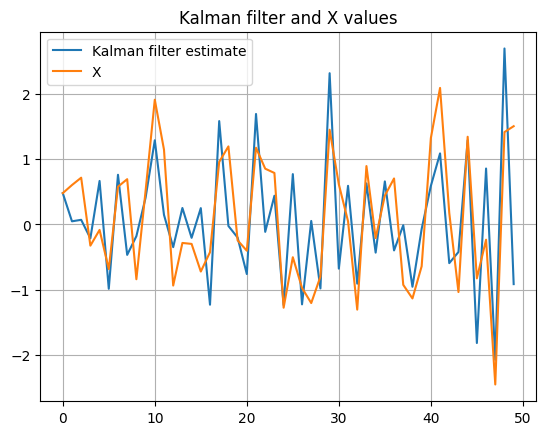

In [188]:
res = kalman_1_d(a, b, Y, X, var_eps, var_delta)
estim = res[1]
plt.plot(estim, label = 'Kalman filter estimate')
plt.plot(X, label = 'X')
plt.legend()
plt.grid(True)
plt.title('Kalman filter and X values')

#### BPF and adaptive BPF

##### Visualize particles

In [189]:
N = 10 
T = 50
smc_x = np.empty([T,N])
smc_w = np.empty([T,N])
smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles
smc_w[0] = np.array([[1/N for i in range (N)]])
res_algo = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)

res_smc = res_algo[2]

In [190]:
res = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)
particles = res[0]
estimate = res[2]
indices = res[3]

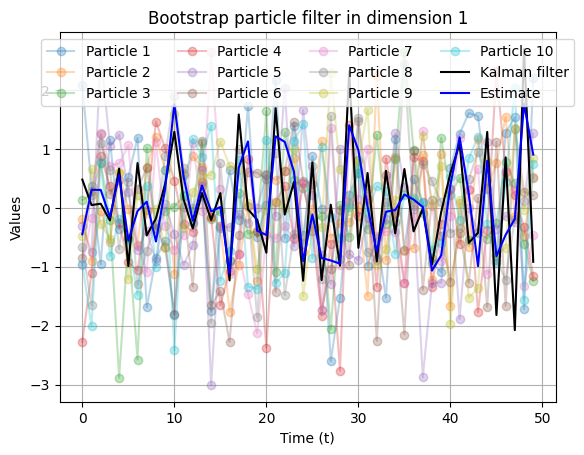

In [191]:
x_abs = np.array([i for i in range(T)])
for i in range(particles.shape[1]):
    plt.plot(x_abs, particles[:, i], 'o-', label='Particle {}'.format(i+1), alpha = 0.3)
plt.plot(estim, color = 'black', label = 'Kalman filter')
plt.plot(estimate, color = 'blue', label = 'Estimate')
plt.xlabel('Time (t)')
plt.ylabel('Values')
plt.title('Bootstrap particle filter in dimension 1')
plt.legend(loc = 'upper center', ncols = 4)
plt.grid(True)
plt.show()

##### Visualize paths

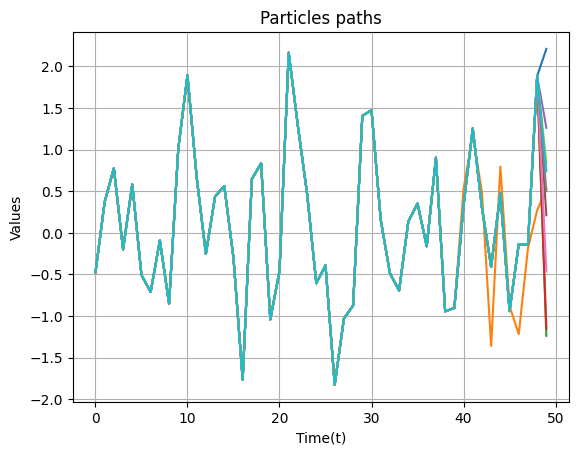

In [192]:
plot_paths(particles, indices)

##### Number of ancestors comparison between the BPF and the adaptive BPF

In [193]:
def compare_number_ancestors(a,b,var_eps, var_delta, N, T, n_rounds):
    x0 = npr.normal(0,1)
    y0 = npr.normal(0,1)

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(a*X[t-1] + npr.normal(0,var_eps**2))
        Y.append(b*X[t] + npr.normal(0,var_delta**2))

    smc_x = np.empty([T,N])
    smc_w = np.empty([T,N])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])

    part_ancetre_ess = [] #nombre d'ancêtres pour la methode avec ess 
    part_ancetre_bpf = [] #nombre d'ancêtres pour la méthode sans ess
    ancetre_ess = [] 
    ancetre_bpf = []
    for i in range (n_rounds):
        res_ess = bpf_ess(smc_x, smc_w, Y, a, var_eps, var_delta,b)
        particles_ess = res_ess[0]
        indices_ess = res_ess[3]
        res_bpf = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)
        particles_bpf = res_bpf[0]
        indices_bpf = res_bpf[3]

        for k in range (N):
            ancetre_ess.append(path(k, particles_ess, indices_ess)[-1])
            ancetre_bpf.append(path(k, particles_bpf, indices_bpf)[-1])
        part_ancetre_bpf.append(len(np.unique(ancetre_bpf)))
        part_ancetre_ess.append(len(np.unique(ancetre_ess)))
        ancetre_ess = []
        ancetre_bpf = []    
    return (part_ancetre_bpf, part_ancetre_ess)


In [194]:
def compare_number_ancestor_a_b(a_list,b_list,var_eps, var_delta, N, T, n_rounds):
    mean_ess = []
    mean_bpf = []
    for a in a_list:
        for b in b_list :
            res = compare_number_ancestors(a,b,var_eps, var_delta, N, T, n_rounds)
            mean_ess.append(np.mean(res[1]))
            mean_bpf.append(np.mean(res[0]))
    A, B = np.meshgrid(a_list, b_list)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surface = (np.array(mean_ess) - np.array(mean_bpf)).reshape(len(a_list), len(b_list))
    s = ax.plot_surface(A, B, surface, cmap='viridis')
    fig.colorbar(s, ax=ax, shrink=0.5, aspect=10)
    ax.set_xlabel('a values')
    ax.set_ylabel('b values')
    ax.set_title(f'Adaptative BPF vs Classical BPF, N = {N}, T = {T}, sdX = {var_eps}, sdY = {var_delta}')
    plt.show()

    

C:\Users\candi\AppData\Local\Temp\ipykernel_6836\2789978390.py:23: RuntimeWarning: invalid value encountered in double_scalars
  return (x, w, sum(w*x)/sum(w), indices)
C:\Users\candi\AppData\Local\Temp\ipykernel_6836\2789978390.py:34: RuntimeWarning: invalid value encountered in divide
  w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
C:\Users\candi\AppData\Local\Temp\ipykernel_6836\2099471465.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return (x, w, sum(w*x)/sum(w), indices)
C:\Users\candi\AppData\Local\Temp\ipykernel_6836\2099471465.py:24: RuntimeWarning: invalid value encountered in divide
  w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights


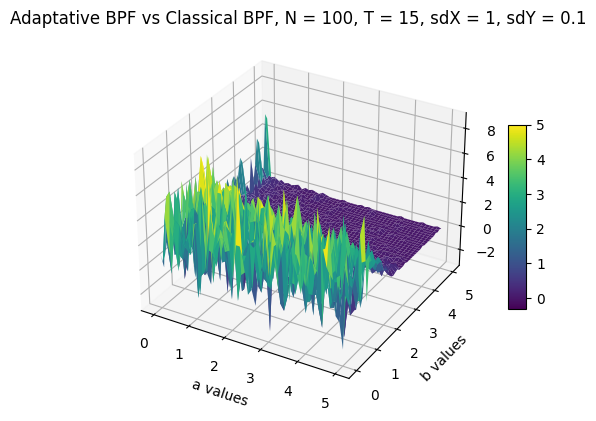

In [195]:
a_list = np.linspace(0,5, 50)
b_list = np.linspace(0,5, 50)
var_eps = 1
var_delta = 0.1
N = 100
T = 15

compare_number_ancestor_a_b(a_list,b_list,var_eps, var_delta, N, T, 10)

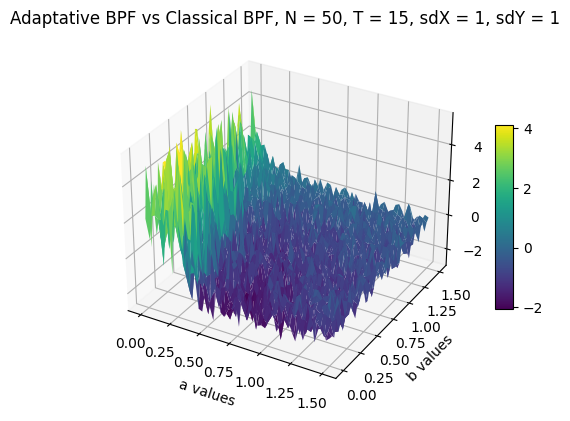

In [196]:
a_list = np.linspace(0,1.5, 50)
b_list = np.linspace(0,1.5,50)
var_eps = 1
var_delta = 1
N = 50
T = 15

compare_number_ancestor_a_b(a_list,b_list,var_eps, var_delta, N, T, 10)

#### Convergence of the BPF to the Kalman filter solution

In [197]:
def boucle_average(n_rep, res, T, N, a, b, var_eps, var_delta, Y):
  to_return = []
  for i in range (n_rep):
    smc_x = np.empty([T,N])
    smc_w = np.empty([T,N])
    smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
    smc_w[0] = np.array([[1/N for i in range (N)]])
    res_smc = np.array(bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)[2])

    RMSE = np.sqrt(sum((res_smc - res)**2)/N)

    to_return.append(RMSE)

    return(np.mean(np.array(to_return)))


In [198]:
def plot_kalman_smc_N_2(N, T, a, b, var_eps, var_delta, n_rep):
  x0 = npr.normal(0,1)
  y0 = npr.normal(0,1)

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(a*X[t-1] + npr.normal(0,var_eps**2))
    Y.append(b*X[t] + npr.normal(0,var_delta**2))

  T = len(Y)
  absciss = np.array([i for i in range (N)])
  to_plot = []
  res = np.array(kalman_1_d( a, b, Y, X, var_eps, var_delta)[1])
  for k in range (1, N):
    RMSE = boucle_average(n_rep, res, T, k, a, b, var_eps, var_delta, Y)

    to_plot.append(RMSE)

  plt.plot(np.log(absciss[1:]), np.log(to_plot))
  plt.xlabel('Log of the number of particles')
  plt.ylabel('Log of the RMSE between the Kalman filter and the Bootstrap PF')
  plt.title('Covergence of the Bootstrap PF to the Kalman filter')
  plt.legend()
  plt.grid(True)
  plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


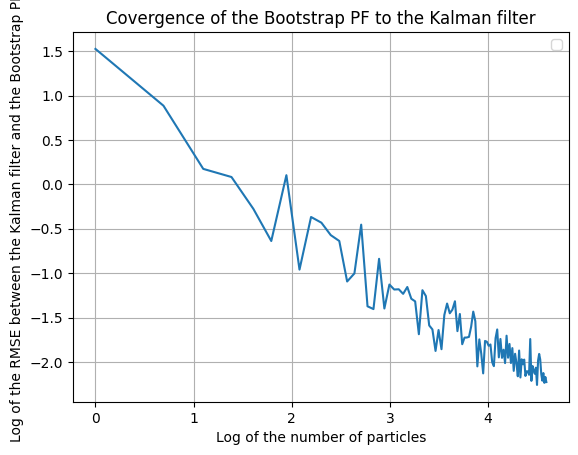

In [199]:
plot_kalman_smc_N_2(100, 10, 0.5, 0.75, 1, 1, 10) #average on 10 rounds 

#### Visualize distributions

In [200]:
#simulate some data following a linear gaussian equation
x0 = npr.normal(0,1)
T = 50
a = 0.1
b = 2
var_eps = 1
var_delta = 1

X = [x0]
Y = [b*x0 + npr.normal(0, var_delta**2)]
for t in range (1,T):
  X.append(a*X[t-1] + npr.normal(0,var_eps**2))
  Y.append(b*X[t] + npr.normal(0,var_delta**2))


N = 1000 #particles
T = 50
smc_x = np.empty([T,N])
smc_w = np.empty([T,N])
smc_x[0] = np.array([[npr.normal(0,1) for i in range (N)]]) #for each time we have N particles which have a value
smc_w[0] = np.array([[1/N for i in range (N)]])
res_algo = bootstrap_filter(smc_x, smc_w, Y, a, var_eps, var_delta,b)

particles = res_algo[0]
weights = res_algo[1]
estimate = res_algo[2]

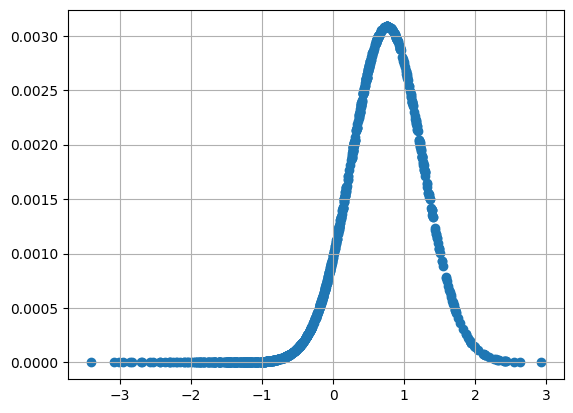

In [201]:
t = 3 # t to select p(x_{t} | y_{1:t})
particles_to_plot = particles[t]
weights_to_plot = weights[t]/np.sum(weights[t])
plt.scatter(particles_to_plot, weights_to_plot)
plt.grid(True)

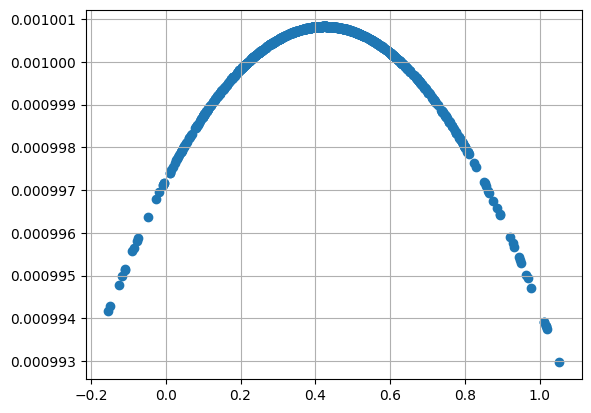

In [202]:
#visualize kalman
res_kalman = kalman_1_d(a, b, Y, X, var_eps, var_delta)
mean = res_kalman[1][t]
cov = res_kalman[2][t]

particles = npr.normal(mean, cov, 1000)
weights = [normal_density(particles[i], mean, cov) for i in range (len(particles))]
weights = weights/np.sum(weights)
plt.scatter(particles, weights)
plt.grid(True)

### Bonus : visualize distributions for non linear model

In [203]:
#generate data
T = 100
x0 = npr.normal(0,1)
X = np.empty(T)
Y = np.empty(T)
X[0] = x0
Y[0] = 0.05*x0**2 + npr.normal(0,0.5)
for t in range (1,T):
    X[t] = 0.5*X[t-1] + 25*X[t-1]/(1+X[t-1]**2) + 8*math.cos(1.2*(t-1)) + npr.normal(0, 0.5)
    Y[t] = 0.05*X[t]**2 + npr.normal(0,0.5)


In [204]:
#bootstrap filter

#implement the bootstrap filter
def step_ex(x_previous, weights_previous, Y_observed,t):
  #resample
  test = multinomial_resampling(weights_previous, x_previous)
  resample = test[0] #multinomial resampling of the particles
  indices = test[1]
  #propagate
  x = np.array(npr.normal(0.5*resample + 25*x_previous/(1+x_previous**2) + 8*math.cos(1.2*(t-1)), 0.5)) #sampling
  #compute weights
  w = np.empty(len(x))
  for i in range (len(x)):
    w[i] = np.array(normal_density(Y_observed, mean = 0.05*x[i]**2, sd = 0.5))
  return (x, w, sum(w*x)/sum(w), indices)

def bpf_ex(N, Y):
  #initialisation
  T = len(Y)
  x = np.empty([T,N])
  w = np.empty([T,N])
  x[0] = npr.normal(0,1,N)
  for i in range (N):
    w[0][i] = normal_density(Y[0], mean = 0.05*x[0][i]**2, sd = 0.5)
  estimate = [sum(w[0]*x[0])/sum(w[0])]
  
  res = []
  indices = [[i for i in range (N)]]
  ESS = []
  for t in range (1,len(Y)):
      res = step_ex(x[t-1], w[t-1], Y[t], t)
      x[t] = np.array(res[0])
      w[t] = np.array(res[1])/sum(np.array(res[1])) #normalized weights
      indices.append(res[3])
      #estimate
      estimate.append(res[2])
      ESS.append(1/(np.sum(w[t]**2)))
  return(x,w,estimate, indices, ESS)



In [205]:
N = 10000
res = bpf_ex(N,Y)

In [206]:
particles = res[0]
weights = res[1]
estimate = res[2]

Text(0.5, 1.0, 'Distribution pour t = 5')

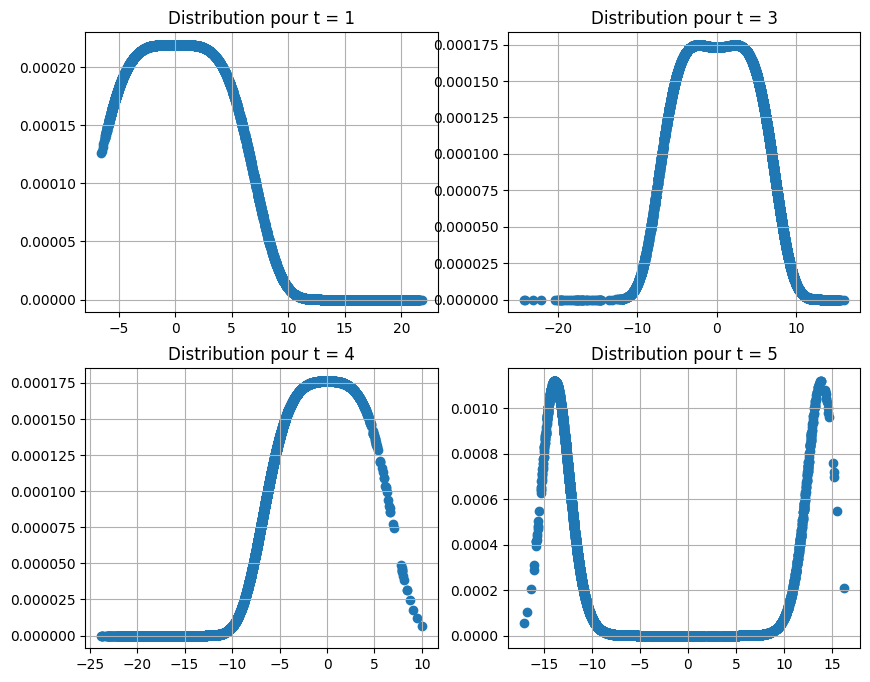

In [207]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

t = 1 #on veut p(x_{t} | y_{1:t})
particles_to_plot = particles[t]
weights_to_plot = weights[t]/sum(weights[t])
ax[0, 0].scatter(particles_to_plot, weights_to_plot)
ax[0, 0].grid(True)
ax[0, 0].set_title(f'Distribution pour t = {t}')

t = 4 #on veut p(x_{t} | y_{1:t})
particles_to_plot = particles[t]
weights_to_plot = weights[t]/sum(weights[t])
ax[1, 0].scatter(particles_to_plot, weights_to_plot)
ax[1, 0].grid(True)
ax[1, 0].set_title(f'Distribution pour t = {t}')

t = 3 #on veut p(x_{t} | y_{1:t})
particles_to_plot = particles[t]
weights_to_plot = weights[t]/sum(weights[t])
ax[0, 1].scatter(particles_to_plot, weights_to_plot)
ax[0, 1].grid(True)
ax[0, 1].set_title(f'Distribution pour t = {t}')

t = 5 #on veut p(x_{t} | y_{1:t})
particles_to_plot = particles[t]
weights_to_plot = weights[t]/sum(weights[t])
ax[1, 1].scatter(particles_to_plot, weights_to_plot)
ax[1, 1].grid(True)
ax[1, 1].set_title(f'Distribution pour t = {t}')



## Dimension D>1

### Simulate data

In [208]:
#simulate data
D = 3 #dimension
#simulate some data following a linear gaussian equation
x0 = np.array([npr.normal(0,1) for i in range (D)])
y0 = np.array([npr.normal(0,1) for i in range (D)])
T = 50
A = 0.2*np.identity(D)
B = 0.4*np.identity(D)
var_eps = np.identity(D)
var_delta = np.identity(D)

X = [x0]
Y = [y0]
Z = [[x0, y0]]
for t in range (1,T):
  X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
  Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
  Z.append([X[t], Y[t]])

### Classical PF (BPF, FAPF, Adaptive BPF)

#### BPF vs Adaptive BPF vs Kalman

##### Visualize

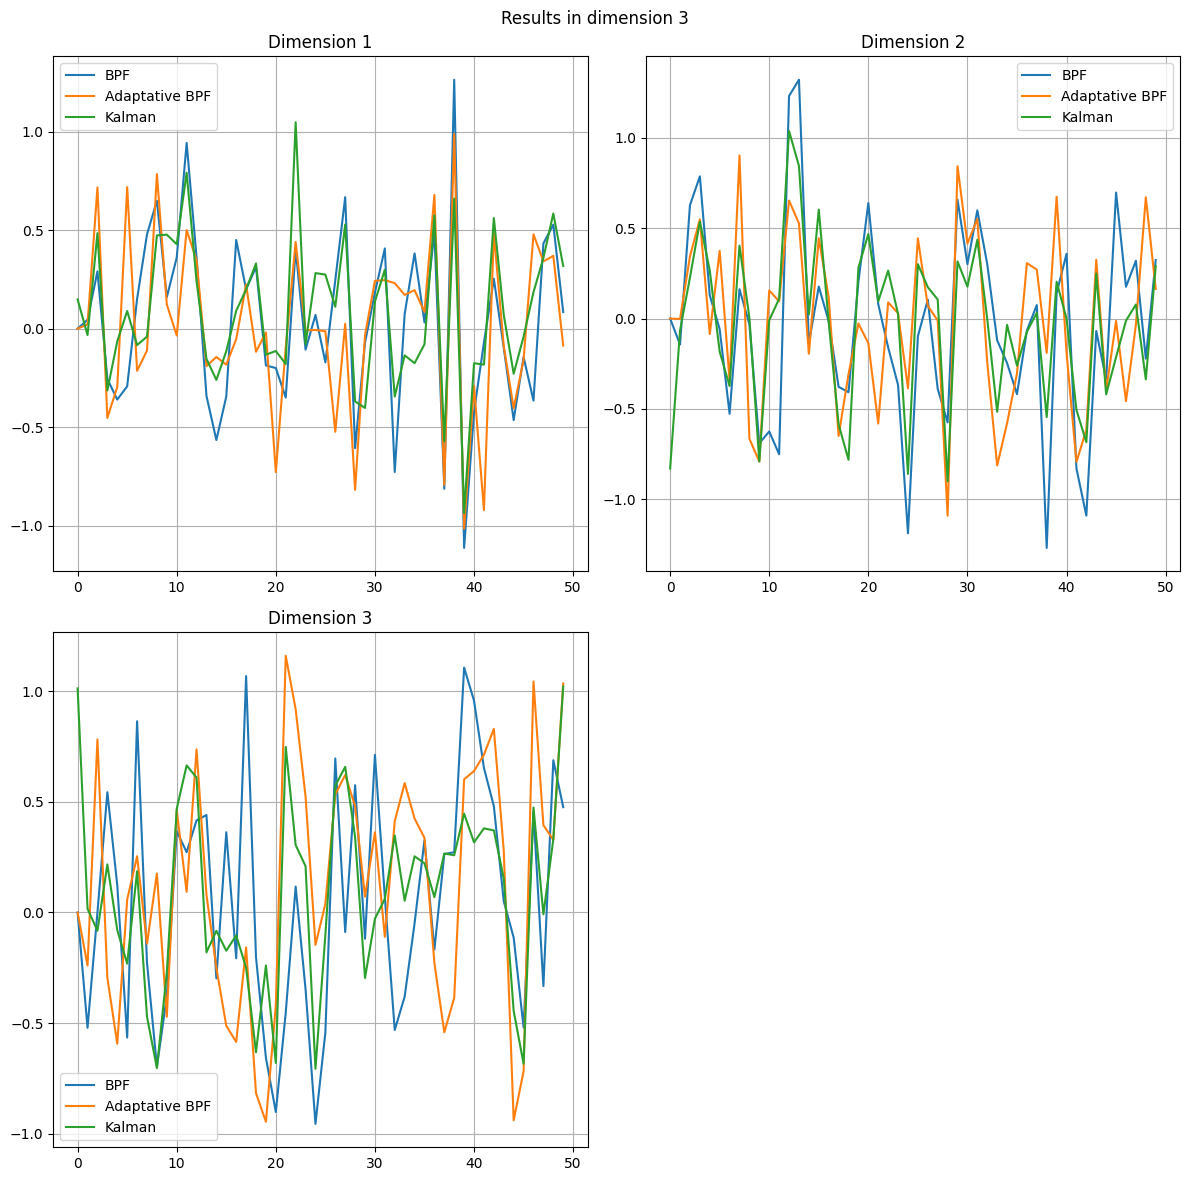

In [209]:
N = 10 #particles
res_ess = bpf_d_ess(Y,A,var_eps,var_delta, B,N)
res_bpf = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D,N,B)
kalman_res = kalman_filter_d(A,B,var_eps, var_delta,Y,T, X[0])
data = [ np.array(res_bpf[2]).transpose(), np.array(res_ess[2]).transpose(), np.array(kalman_res[0]).transpose()]
plot_multiple_graphs(data, [ 'BPF', 'Adaptative BPF', 'Kalman'])

##### Convergence BPF Kalman

In [210]:
def boucle_kalman_smc_N_dim_d_average(mu_x, k, n_rep, Y, T, A, var_eps, var_delta, D, B, X):
  to_return_kalman = []
  to_return_X = []
  for z in range (n_rep):
    res_smc = bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, k,B)[2]

    RMSE = RMSE_by_coordinate(mu_x, res_smc)
    to_return_kalman.append(RMSE)
    RMSE = RMSE_by_coordinate(X, res_smc)
    to_return_X.append(RMSE)

  return(np.mean(np.array(to_return_kalman), axis = 0), np.mean(np.array(to_return_X), axis = 0))


In [211]:
def plot_kalman_smc_N_dim_d_average(D, T, A, B, var_eps, var_delta, N, n_rep):
  #simulate the data
  x0 = np.array([npr.normal(0,1) for i in range (D)])
  y0 = np.array([npr.normal(0,1) for i in range (D)])

  X = [x0]
  Y = [y0]
  for t in range (1,T):
    X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
    Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])

  to_plot_kalman = []
  to_plot_X = []

  #kalman filter
  res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, X[0])
  mu_x = res[0]

  #smc for different values of N
  for k in range (1, N):
    res_boucle = boucle_kalman_smc_N_dim_d_average(mu_x, k, n_rep, Y, T, A, var_eps, var_delta, D, B, np.array(X))
    RMSE_kalman = res_boucle[0]
    RMSE_X = res_boucle[1]
    to_plot_kalman.append(RMSE_kalman)
    to_plot_X.append(RMSE_X)

  to_plot_kalman = np.array(to_plot_kalman).transpose()
  to_plot_X = np.array(to_plot_X).transpose()
  return(to_plot_kalman, to_plot_X)

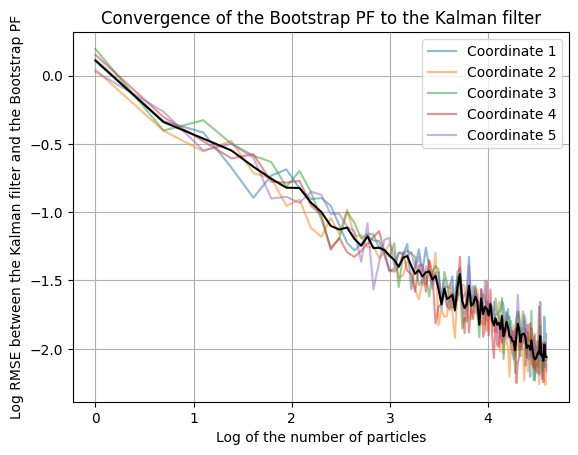

In [212]:
to_plot = plot_kalman_smc_N_dim_d_average(5, 10, 0.2*np.identity(5), 0.4*np.identity(5), np.identity(5), np.identity(5), 100, 5)[0]
absciss = np.array([i for i in range (100)])
for i in range(len(to_plot)): #len(to_plot) = D
    plt.plot(np.log(absciss[1:]), np.log(to_plot[i]), '-', label='Coordinate {}'.format(i+1), alpha = 0.5)
plt.plot(np.log(absciss[1:]), np.log(np.mean(to_plot, axis = 0)), color = 'black')
plt.xlabel('Log of the number of particles')
plt.ylabel('Log RMSE between the Kalman filter and the Bootstrap PF')
plt.title('Convergence of the Bootstrap PF to the Kalman filter')
plt.legend()
plt.grid(True)
plt.show()

##### Change the noise level

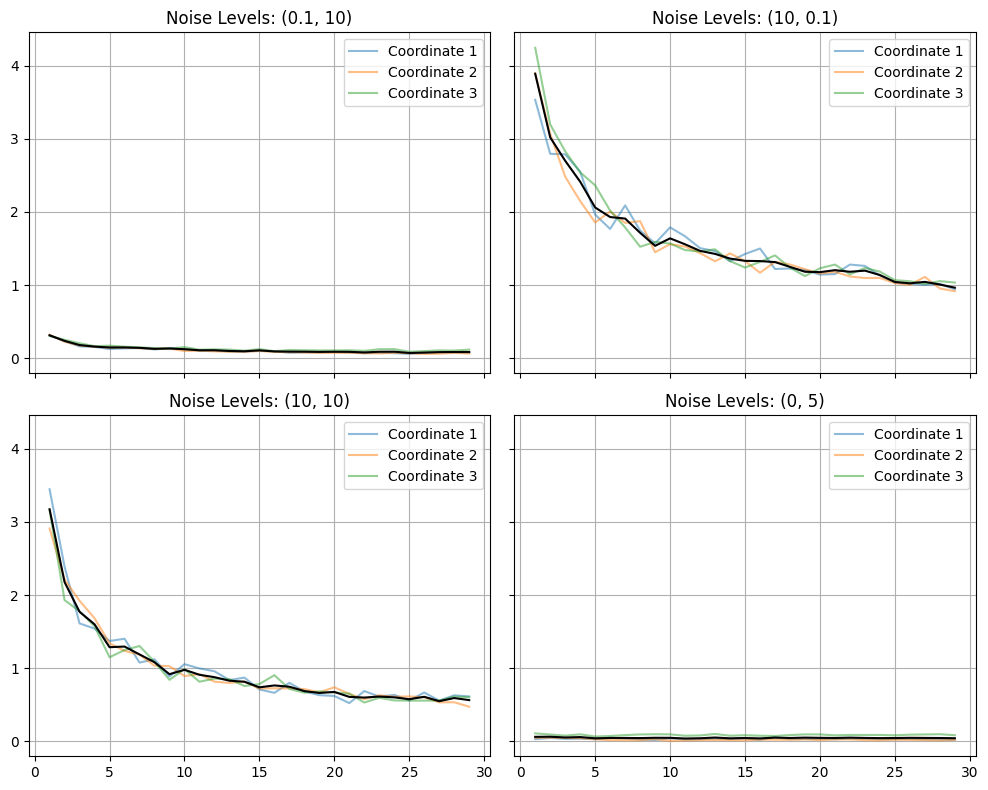

In [213]:
noise_levels = [[0.1, 10], [10, 0.1], [10, 10], [0, 5]]
N = 30
D = 3
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
absciss = np.array([i for i in range (N)])

for i in range (len(noise_levels)):
  to_plot = plot_kalman_smc_N_dim_d_average(D, 20, 0.2*np.identity(D), 0.4*np.identity(D), noise_levels[i][0]*np.identity(D), noise_levels[i][1]*np.identity(D), N, 5)[0]
  for z in range(len(to_plot)): #len(to_plot) = D
    axes[i // 2, i % 2].plot(absciss[1:], to_plot[z], '-', label='Coordinate {}'.format(z+1), alpha = 0.5)
  axes[i // 2, i % 2].plot(absciss[1:], np.mean(to_plot, axis = 0), color = 'black')
  noise_str = 'Noise Levels: ({}, {})'.format(noise_levels[i][0], noise_levels[i][1])
  axes[i // 2, i % 2].set_title(noise_str)
  axes[i // 2, i % 2].grid(True)
  axes[i // 2, i % 2].legend()

plt.tight_layout()
plt.show()

#### Degeneracy of the BPF when D increases 

In [214]:
def bpf_kalman_d(D_max, N, a, b, var_e, var_d, T):
    to_plot = []
    absciss = np.array([i for i in range (2, D_max)])
    interm = []
    for D in range (2, D_max):
        for k in range (5):
            x0 = np.array([npr.normal(0,1) for i in range (D)])

            A = a*np.identity(D)
            B = b*np.identity(D)
            var_eps = var_e*np.identity(D)
            var_delta = var_d*np.identity(D)

            X = [x0]
            Y = [np.dot(A, x0) + npr.normal(0,1,D)]
            for t in range (1,T):
                X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
                Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])

            #kalman filter
            res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, x0)
            mu_x = res[0]

            res_smc = bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, N,B)[2]

            RMSE = RMSE_by_coordinate(mu_x, res_smc)
            interm.append(np.mean(RMSE))
        
        to_plot.append(np.mean(interm))
        interm = []

    plt.plot(absciss, to_plot, color = 'black')
    plt.xlabel('Dimension')
    plt.ylabel('RMSE between the Kalman filter and the Bootstrap PF')
    plt.title('Convergence of the Bootstrap PF to the Kalman filter')
    plt.grid(True)
    plt.show()

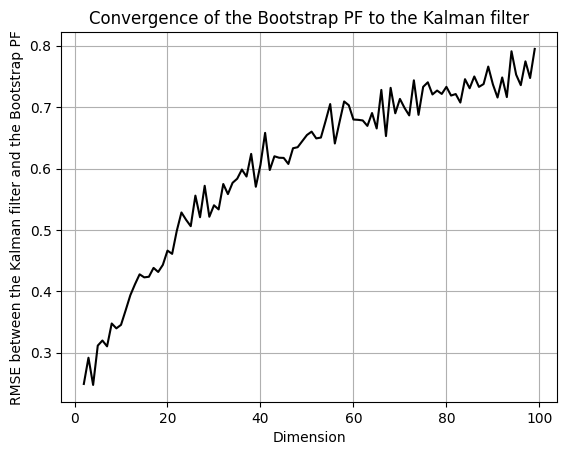

In [215]:
bpf_kalman_d(100, 20, 0.2, 0.4, 1, 1, 10)

#### BPF vs FAPF

##### Convergence to Kalman

In [216]:
def compare_kalman_pf_fapf_RMSE(D, T, A, B, var_eps, var_delta, N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function):
    #simulate the data 
    x0 = np.array([npr.normal(0,1) for i in range (D)])
    y0 = np.array([npr.normal(0,1) for i in range (D)])

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(np.dot(A, X[t-1]) + [npr.normal(0,1) for i in range (D)]) #for the noise since we took the identity matrix
        Y.append(np.dot(B, X[t]) + [npr.normal(0,1) for i in range (D)])
    

    absciss = np.array([i for i in range (N)])
    to_plot_smc = []
    to_plot_apf = []

    #kalman filter 
    res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, X[0])
    mu_x = np.array(res[0])

    #bootstrap filter and APF for different values of N
    for k in range (1, N):
        res_smc = bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, k,B)[2]

        RMSE_smc = RMSE_by_coordinate(mu_x, res_smc)
        to_plot_smc.append(RMSE_smc)


        #APF
        x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
        res_apf = fully_adapted(x_0, D, T, Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, k)[2]
        RMSE_apf = RMSE_by_coordinate(mu_x, res_apf)
        to_plot_apf.append(RMSE_apf)

    to_plot_smc = np.array(to_plot_smc).transpose()
    to_plot_apf = np.array(to_plot_apf).transpose()
    #for i in range(len(to_plot_smc)): #len(to_plot) = D
        #plt.plot(absciss[1:], to_plot_smc[i], '-', label='BPF Coordinate {}'.format(i+1), alpha = 0.5)
        #plt.plot(absciss[1:], to_plot_apf[i], '-', label='APF Coordinate {}'.format(i+1), alpha = 0.5)
    plt.plot(np.log(absciss[1:]), np.log(np.mean(to_plot_smc, axis = 0)), color = 'black', label = 'BPF')
    plt.plot(np.log(absciss[1:]), np.log(np.mean(to_plot_apf, axis = 0)), color = 'blue', label = 'FAPF')
    plt.xlabel('Number of particles')
    plt.ylabel('RMSE between the Kalman filter and the PF considered')
    plt.title('Convergence of the particles filter to the Kalman filter')
    plt.legend()
    plt.grid(True)
    plt.show()


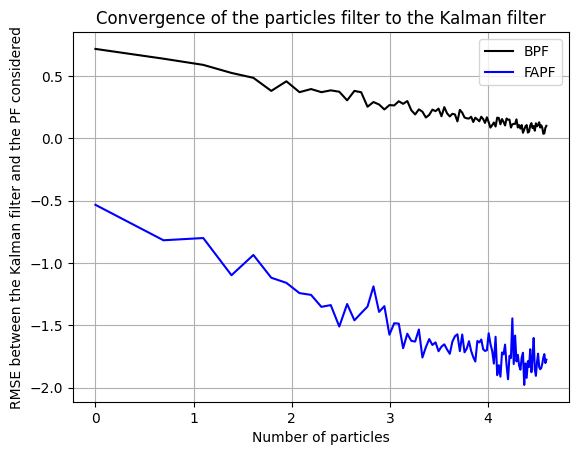

In [217]:
D = 5 #dimension
T = 50
A = 0.2*np.identity(D)
B = 0.4*np.identity(D)
var_eps = np.identity(D)
var_delta = 0.1*np.identity(D)
compare_kalman_pf_fapf_RMSE(D,30, A, B, var_eps, var_delta, 100, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function)

##### Change the noise level

In [218]:
def RMSE_noise(mu_x, res):
    T = len(mu_x)
    D = len(mu_x[0])
    a = np.zeros(T) 
    for t in range (T):
        for d in range (D):
            a[t] = a[t] + ((mu_x[t][d]-res[t][d])**2)/D #mean RMSE on the dimension for each t and we sum 
    return (np.sum(a[t]))

In [219]:
def compare_kalman_pf_fapf_RMSE_not_plot(D, T, A, B, var_eps, var_delta, N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function):
    #simulate the data 
    x0 = np.array([npr.normal(0,1) for i in range (D)])
    y0 = np.array([npr.normal(0,1) for i in range (D)])

    X = [x0]
    Y = [y0]
    for t in range (1,T):
        X.append(np.dot(A, X[t-1]) + npr.multivariate_normal(np.zeros(D), var_eps)) 
        Y.append(np.dot(B, X[t]) + npr.multivariate_normal(np.zeros(D), var_delta))
    

    to_plot_smc = []
    to_plot_apf = []

    #kalman filter 
    res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, X[0])
    mu_x = np.array(res[0])

    #bootstrap filter and APF for different values of N
    for k in range (1, N):
        res_smc = bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, k,B)[2]

        RMSE_smc = RMSE_by_coordinate(mu_x, res_smc)
        to_plot_smc.append(np.mean(RMSE_smc))


        #APF
        x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
        res_apf = fully_adapted(x_0, D, T, Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, k)[2]
        RMSE_apf = RMSE_by_coordinate(mu_x, res_apf)
        to_plot_apf.append(np.mean(RMSE_apf))
        
    #to_plot_smc = np.array(to_plot_smc).transpose()
    #to_plot_apf = np.array(to_plot_apf).transpose()

    return(to_plot_smc, to_plot_apf, np.array(X), mu_x, res_smc, res_apf)

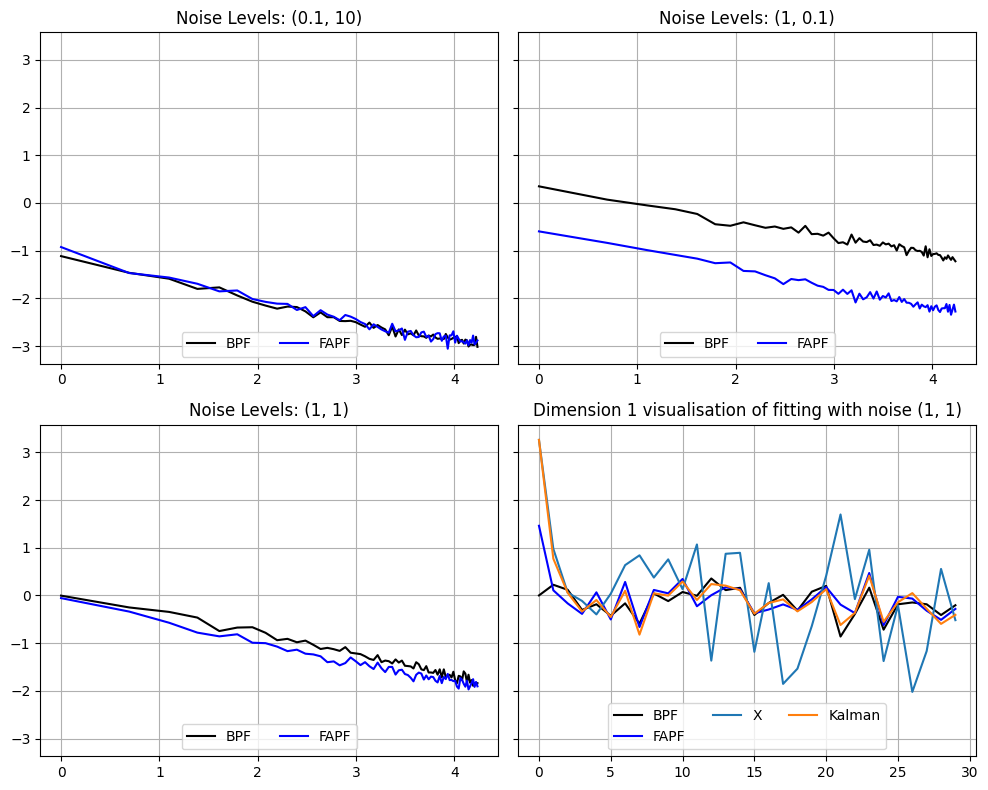

In [220]:
noise_levels = [[0.1, 10], [1, 0.1], [1, 1]]
N = 70
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey = True)
absciss = np.array([i for i in range (1,N)])
D = 5
A = 0.2*np.identity(D)
B = 0.4*np.identity(D)
T = 30

for i in range (len(noise_levels)):
  res = compare_kalman_pf_fapf_RMSE_not_plot(D, T, A, B, noise_levels[i][0]*np.identity(D), noise_levels[i][1]*np.identity(D), N, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function)
  to_plot_smc = res[0]
  to_plot_apf = res[1]
  #for z in range(len(to_plot_smc)): #len(to_plot) = D
    #axes[i // 2, i % 2].plot(absciss[1:], to_plot_smc[z], '-', label='BPF Coordinate {}'.format(z+1), alpha = 0.5)
    #axes[i // 2, i % 2].plot(absciss[1:], to_plot_apf[z], '-', label='FAPF Coordinate {}'.format(z+1), alpha = 0.5)
  axes[i // 2, i % 2].plot(np.log(absciss), np.log(to_plot_smc), color = 'black', label = 'BPF')
  axes[i // 2, i % 2].plot(np.log(absciss), np.log(to_plot_apf), color = 'blue', label = 'FAPF')
  noise_str = 'Noise Levels: ({}, {})'.format(noise_levels[i][0], noise_levels[i][1])
  axes[i // 2, i % 2].set_title(noise_str)
  axes[i // 2, i % 2].grid(True)
  axes[i // 2, i % 2].legend(loc = 'lower center', ncols = 3)

X = res[2]
mu_x = res[3]
res_smc = res[4]
res_apf = res[5]
absciss = [i for i in range (T)]
axes[1,1].plot(absciss, np.array(res_smc).transpose()[0], color = 'black', label = 'BPF')
axes[1,1].plot(absciss, np.array(res_apf).transpose()[0], color = 'blue', label = 'FAPF')
axes[1,1].plot(absciss, np.array(X).transpose()[0], label = 'X')
axes[1,1].plot(absciss, np.array(mu_x).transpose()[0], label = 'Kalman')
axes[1,1].set_title('Dimension 1 visualisation of fitting with noise (1, 1)')
axes[1,1].grid(True)
axes[1,1].legend(loc = 'lower center', ncols = 3)

plt.tight_layout()
plt.show()


#### Visualize distributions

In [221]:
D = 2
A = np.array([[0.1, 0.5], [0.4, 0.3]])
B = np.array([[0, 1], [1, 0]])
var_eps = 0.1*np.identity(D)
var_delta = 0.1*np.identity(D)
T = 20
N = 4000
X, Y = generate(A, B, var_eps, var_delta, T, D)

res_boot = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D,N,B)

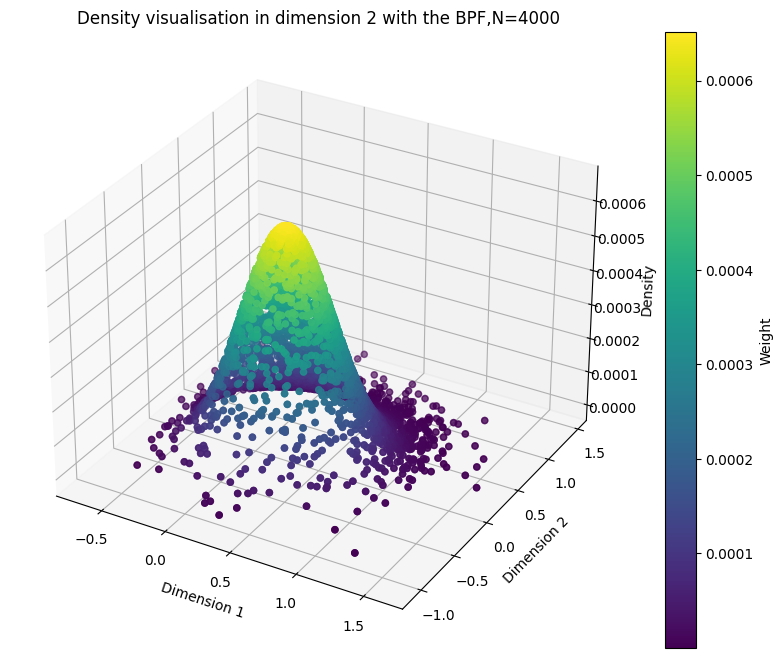

In [222]:
t = 19
particles = res_boot[0]
weights = res_boot[1]
#np.shape(particles[t])

# Create a 3D meshgrid
x = particles[t][0]
y = particles[t][1]
z = weights[t]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

cbar = plt.colorbar(ax.scatter(x, y, z, c=z, cmap='viridis', marker='o'))
cbar.set_label('Weight')

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Density')
ax.set_title(f'Density visualisation in dimension 2 with the BPF,N={N}')

# Display the plot
plt.show()


In [223]:
D = 2
A = np.array([[0.1, 0.5], [0.4, 0.3]])
B = np.array([[0, 1], [1, 0]])
var_eps = np.identity(D)
var_delta = np.identity(D)
T = 20
X, Y = generate(A, B, var_eps, var_delta, T, D)

kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, X[0])

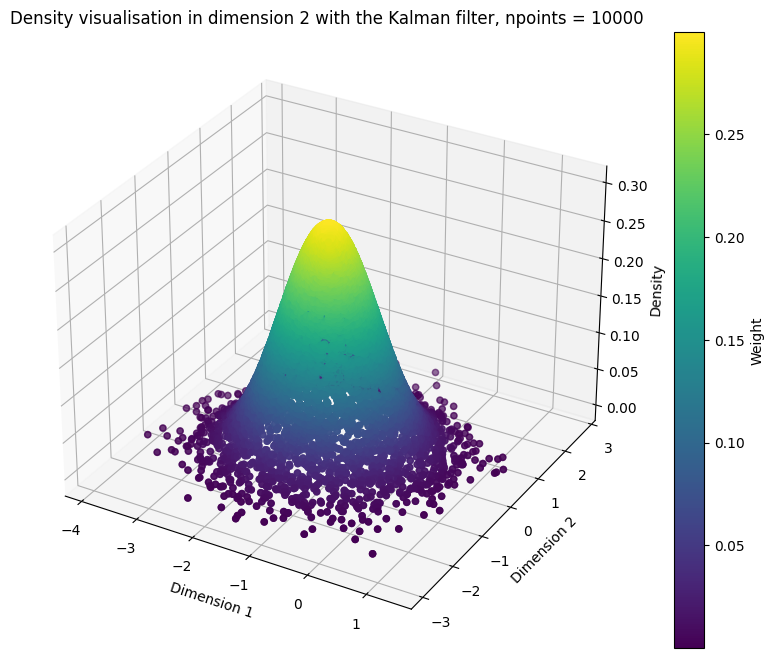

In [224]:
#simulate points following the distribution and then plot
n_points = 10000
t = 19
mean = kalman_res[0][t]
cov = kalman_res[1][t]

points = npr.multivariate_normal(mean, cov, n_points) #generate points
weights = [normal_density_vector_d(points[i], mean, cov) for i in range (len(points))]

# Create a 3D meshgrid
x = points.transpose()[0]
y = points.transpose()[1]
z = weights

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

cbar = plt.colorbar(ax.scatter(x, y, z, c=z, cmap='viridis', marker='o'))
cbar.set_label('Weight')

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Density')
ax.set_title(f'Density visualisation in dimension 2 with the Kalman filter, npoints = {n_points}')

# Display the plot
plt.show()


### Divide and Conquer

#### RMSE comparison with the BPF

##### For different values of a,b

In [225]:
def RMSE_3d_DAC_a_b(a_values, b_values, var_eps, var_delta, T, N, D):
    RMSE_plot = np.empty((len(a_values), len(b_values)))
    for i in range (len(a_values)) :
        for k in range (len(b_values)) :
            A = a_values[i]*np.identity(D) 
            B = b_values[k]*np.identity(D)
            X, Y = generate(A, B, var_eps, var_delta, T, D)

            mu_x = np.array([npr.normal(0,1) for i in range (D)])
            kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)

            res_boot = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D,N,B)
            res = dac_procedure_all(Y, A, B, var_eps, var_delta, N)

            interm = RMSE_compare(kalman_res[0], res_boot[2], res[2])
            RMSE_plot[i][k] = np.mean(np.array(interm[0])) - np.mean(np.array(interm[1]))
    
    # Create a meshgrid for A and B values
    A_grid, B_grid = np.meshgrid(a_values, b_values)

    return (A_grid, B_grid, np.array(RMSE_plot))
    


In [ ]:
D = 10
n_points = 10
a_values = np.linspace(0.1, 1, n_points)
b_values = np.linspace(0.1, 1, n_points)
var_eps = np.identity(D)
var_delta = np.identity(D)
T = 10
N = 30

D_10_res = RMSE_3d_DAC_a_b(a_values, b_values, var_eps, var_delta, T, N, D)


D = 40
var_eps = np.identity(D)
var_delta = np.identity(D)
D_40_res = RMSE_3d_DAC_a_b(a_values, b_values, var_eps, var_delta, T, N, D)


D = 70
var_eps = np.identity(D)
var_delta = np.identity(D)
D_70_res = RMSE_3d_DAC_a_b(a_values, b_values, var_eps, var_delta, T, N, D)

D = 100
var_eps = np.identity(D)
var_delta = np.identity(D)
D_100_res = RMSE_3d_DAC_a_b(a_values, b_values, var_eps, var_delta, T, N, D)


plt.figure()
#plt.scatter(A_flat, B_flat, c=RMSE_flat, cmap='viridis', s=100)  # 's' controls marker size
contour = plt.contourf(D_100_res[0], D_100_res[1], D_100_res[2], levels=20, cmap='viridis')
plt.colorbar(label='RMSE difference (BPF - DAC)')
plt.xlabel('a Values')
plt.ylabel('b Values')
plt.title('RMSE difference between the BPF and the DAC')


contour_curve = plt.contour(D_100_res[0], D_100_res[1], D_100_res[2], levels=[0], colors='red')
plt.clabel(contour_curve, fmt='D=100', inline=True, fontsize=10, colors='red')
contour_curve = plt.contour(D_70_res[0], D_70_res[1], D_70_res[2], levels=[0], colors='blue', linestyles = 'dashed')
plt.clabel(contour_curve, fmt='D=70', inline=True, fontsize=10, colors='blue')
contour_curve = plt.contour(D_40_res[0], D_40_res[1], D_40_res[2], levels=[0], colors='purple', linestyles = 'dashed')
plt.clabel(contour_curve, fmt='D=40', inline=True, fontsize=10, colors='purple')
contour_curve = plt.contour(D_10_res[0], D_10_res[1], D_10_res[2], levels=[0], colors='black', linestyles = 'dashed')
plt.clabel(contour_curve, fmt='D=20', inline=True, fontsize=10, colors='black')


##### For different noise levels

In [ ]:
def RMSE_3d_DAC_var(A, B, var_eps_values, var_delta_values, T, N, D):
    RMSE_plot = np.empty((len(var_eps_values), len(var_delta_values)))
    for i in range (len(var_eps_values)) :
        for k in range (len(var_delta_values)) :
            var_eps = var_eps_values[i]*np.identity(D) 
            var_delta = var_delta_values[k]*np.identity(D)
            X, Y = generate(A, B, var_eps, var_delta, T, D)

            mu_x = np.array([npr.normal(0,1) for i in range (D)])
            kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)

            res_boot = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D,N,B)
            res = dac_procedure_all(Y, A, B, var_eps, var_delta, N)

            interm = RMSE_compare(kalman_res[0], res_boot[2], res[2])
            RMSE_plot[i][k] = np.mean(np.array(interm[0])) - np.mean(np.array(interm[1]))
    
    # Create a meshgrid for A and B values
    eps_grid, delt_grid = np.meshgrid(var_eps_values, var_delta_values)

    return (eps_grid, delt_grid, np.array(RMSE_plot))
    


In [ ]:
D = 10
n_points = 10
eps_values = np.linspace(0.1, 1, n_points)
delt_values = np.linspace(0.1, 1, n_points)
A = 0.5*np.identity(D)
B = 0.7*np.identity(D)
T = 10
N = 30

D_10_res = RMSE_3d_DAC_var(A, B, eps_values, delt_values, T, N, D)


D = 40
A = 0.5*np.identity(D)
B = 0.7*np.identity(D)
D_40_res = RMSE_3d_DAC_var(A, B, eps_values, delt_values, T, N, D)


D = 100
A = 0.5*np.identity(D)
B = 0.7*np.identity(D)
D_100_res = RMSE_3d_DAC_var(A, B, eps_values, delt_values, T, N, D)


plt.figure()
contour = plt.contourf(D_100_res[0], D_100_res[1], D_100_res[2], levels=20, cmap='viridis')
plt.colorbar(label='RMSE difference (BPF - DAC)')
plt.xlabel('epsilon Values')
plt.ylabel('delta Values')
plt.title('RMSE difference between the BPF and the DAC')


contour_curve = plt.contour(D_100_res[0], D_100_res[1], D_100_res[2], levels=[0], colors='red')
plt.clabel(contour_curve, fmt='D=100', inline=True, fontsize=10, colors='red')
contour_curve = plt.contour(D_40_res[0], D_40_res[1], D_40_res[2], levels=[0], colors='purple', linestyles = 'dashed')
plt.clabel(contour_curve, fmt='D=40', inline=True, fontsize=10, colors='purple')
contour_curve = plt.contour(D_10_res[0], D_10_res[1], D_10_res[2], levels=[0], colors='black', linestyles = 'dashed')
plt.clabel(contour_curve, fmt='D=20', inline=True, fontsize=10, colors='black')


##### Convergence to the Kalman filter when N increases

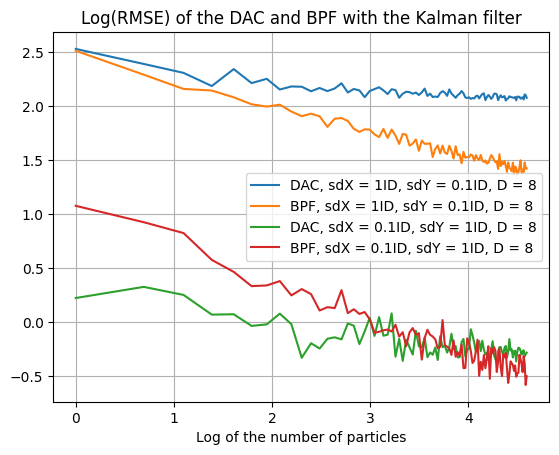

In [227]:
A_values = [0.5, 0.9]
B_values = [1.3, 0.1]
var_eps_values = [1, 0.1]
var_delta_values = [0.1, 1]
N = 100
D_values = [i for i in range (1,50)]
T = 30
D0 = 8

A = 0.5*np.identity(D0)
B = 0.5*np.identity(D0)
var_eps = var_eps_values[0]*np.identity(D0)
var_delta = var_delta_values[0]*np.identity(D0)
X, Y = generate(A, B, var_eps, var_delta, T, D0)
mu_x = np.array([npr.normal(0,1) for i in range (D0)])
kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)[0]
RMSE_dac_kalman_1 = []
RMSE_boot_kalman_1 = []
for n in range (1,N):
    res_dac = dac_procedure_all(Y, A, B, var_eps, var_delta, n)
    res_boot = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D0,n,B)

    RMSE_res = RMSE_compare(kalman_res, np.array(res_dac[2]), np.array(res_boot[2])) #RMSE on the time 
    
    RMSE_dac_kalman_1.append(sum(RMSE_res[0]))
    RMSE_boot_kalman_1.append(sum(RMSE_res[1]))

var_eps = var_eps_values[1]*np.identity(D0)
var_delta = var_delta_values[1]*np.identity(D0)
X, Y = generate(A, B, var_eps, var_delta, T, D0)
mu_x = np.array([npr.normal(0,1) for i in range (D0)])
kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)[0]
RMSE_dac_kalman_2 = []
RMSE_boot_kalman_2 = []
for n in range (1,N):
    res_dac = dac_procedure_all(Y, A, B, var_eps, var_delta, n)
    res_boot = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D0,n,B)

    RMSE_res = RMSE_compare(kalman_res, np.array(res_dac[2]), np.array(res_boot[2])) #RMSE on the time 
    
    RMSE_dac_kalman_2.append(sum(RMSE_res[0]))
    RMSE_boot_kalman_2.append(sum(RMSE_res[1]))

abs = [i for i in range (1,N)]
plt.plot(np.log(abs), np.log(RMSE_dac_kalman_1), label = f'DAC, sdX = {var_eps_values[0]}ID, sdY = {var_delta_values[0]}ID, D = {D0}')
plt.plot(np.log(abs), np.log(RMSE_boot_kalman_1), label = f'BPF, sdX = {var_eps_values[0]}ID, sdY = {var_delta_values[0]}ID, D = {D0}')
plt.plot(np.log(abs), np.log(RMSE_dac_kalman_2), label = f'DAC, sdX = {var_eps_values[1]}ID, sdY = {var_delta_values[1]}ID, D = {D0}')
plt.plot(np.log(abs), np.log(RMSE_boot_kalman_2), label = f'BPF, sdX = {var_eps_values[1]}ID, sdY = {var_delta_values[1]}ID, D = {D0}')
plt.grid(True)
plt.title('Log(RMSE) of the DAC and BPF with the Kalman filter')
plt.xlabel('Log of the number of particles')
plt.legend()

### Nested smc

#### Visualize

In [ ]:
D = 10 #dimension
A = 0.2*np.identity(D)
B = 1.1*np.identity(D)
T = 20
var_eps = np.identity(D)
var_delta = np.identity(D)
X, Y = generate(A, B, var_eps, var_delta, T, D)

N = 10
M = 11
res = nested_smc_new(N, M, A, B, var_delta, var_eps, Y, D, T)

In [ ]:
res_bpf = bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, N*M, B)

In [ ]:
mu_x = np.array([npr.normal(0,1) for i in range (D)])
kalman_estimate = kalman_filter_d(A, B, var_eps, var_delta, Y,T, mu_x)

In [ ]:
x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
res_fully = fully_adapted(x_0, D, T, Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, M*N)

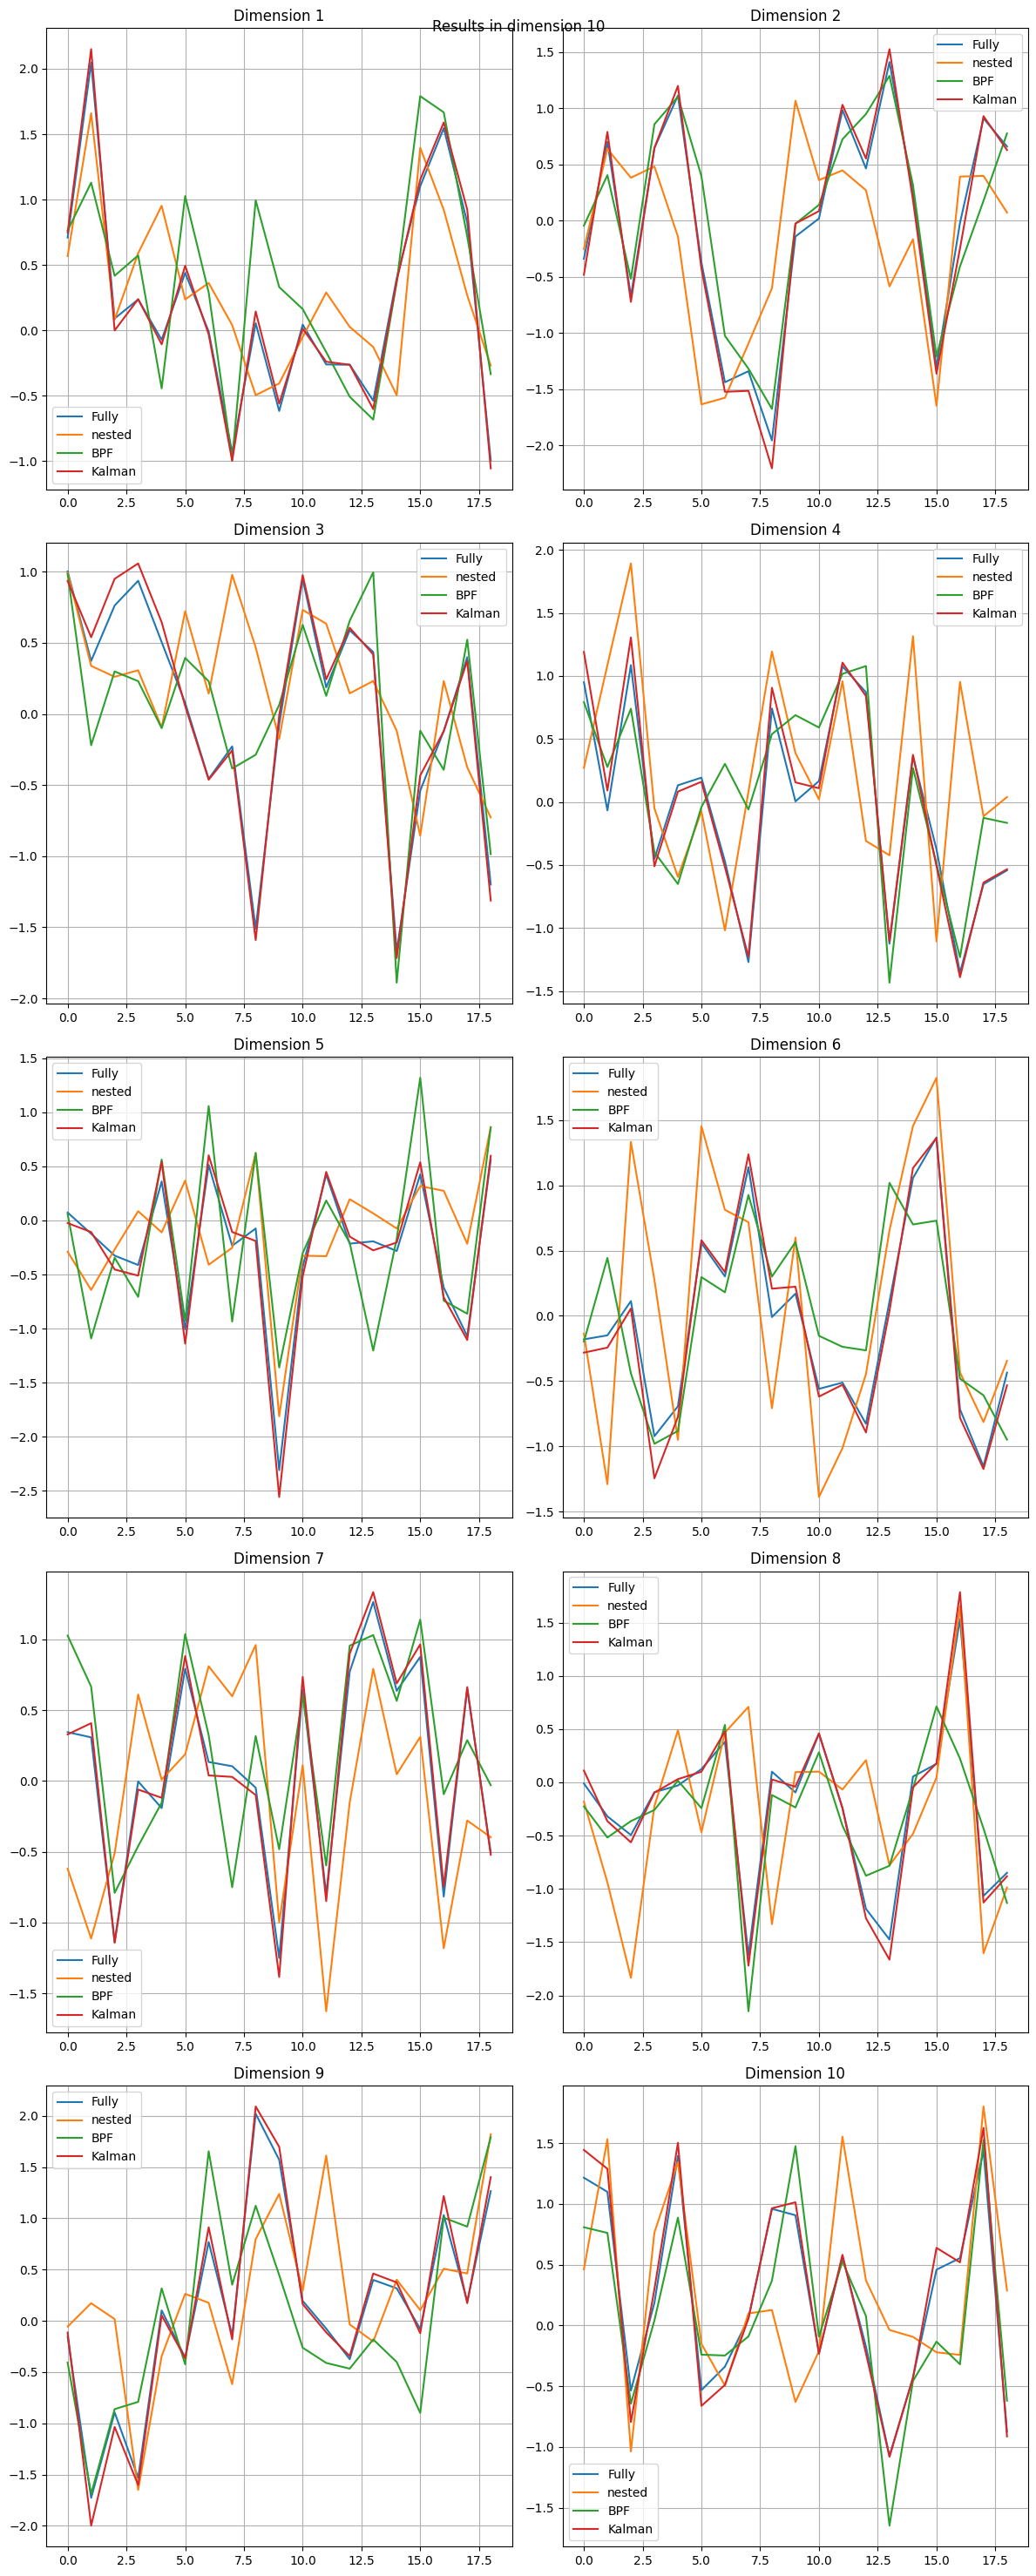

In [ ]:
plot_multiple_graphs([np.array(res_fully[2])[1:].transpose(), np.array(res[1])[1:].transpose(), np.array(res_bpf[2])[1:].transpose(), np.array(kalman_estimate[0])[1:].transpose()], ['Fully','nested', 'BPF', 'Kalman'])

#### Convergence to FAPF or Kalman

In [ ]:
## increasing the number of inner particles
def nested_particles_2(N, M, T, D, Y, A, B, var_eps, var_delta):
    RMSE_nested_time = []
    RMSE_bpf_time = []
    #mu_x = np.array([npr.normal(0,1) for i in range (D)])
    #res_kalman = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)
    #estimate_kalman = res_kalman[0]
    smc_part = N*M
    x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
    res_fully = fully_adapted(x_0, D, T,Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, smc_part)
    estimate_fully = res_fully[2]
    
    for m in range (1, M):
        print(m)
        smc_part = m*N
        #run the nested smc
        res_nested = nested_smc_new(N, m, A, B, var_delta, var_eps, Y, D, T)
        nested_estimate = res_nested[1]

        #bpf
        res_bpf = bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, smc_part,B)

        RMSE_res = RMSE_compare(np.array(estimate_fully), nested_estimate, np.array(res_bpf[2])) 
        
        RMSE_nested_time.append(sum(RMSE_res[0]))
        RMSE_bpf_time.append(sum(RMSE_res[1]))

    #plot
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    plt.plot(RMSE_nested_time, color = 'black', label = 'Nested')
    plt.plot(RMSE_bpf_time, color = 'blue', label = 'BPF')
    plt.title(f'RMSE with FAPF, N = {N}')
    plt.xlabel('Number of particles M')
    plt.grid(True)
    plt.legend()
    return (RMSE_nested_time, RMSE_bpf_time)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


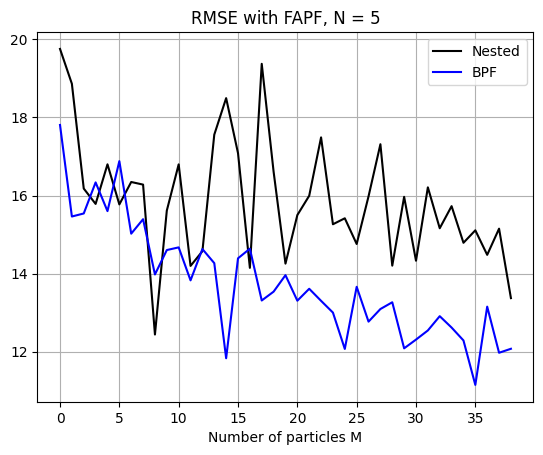

In [ ]:
N = 5
M = 40
D = 20 #dimension
A = 0.2*np.identity(D)
B = 1.1*np.identity(D)
T = 10
var_eps = np.identity(D)
var_delta = np.identity(D)
X, Y = generate(A, B, var_eps, var_delta, T, D)

nested_part_res = nested_particles_2(N, M, T, D, Y, A, B, var_eps, var_delta)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


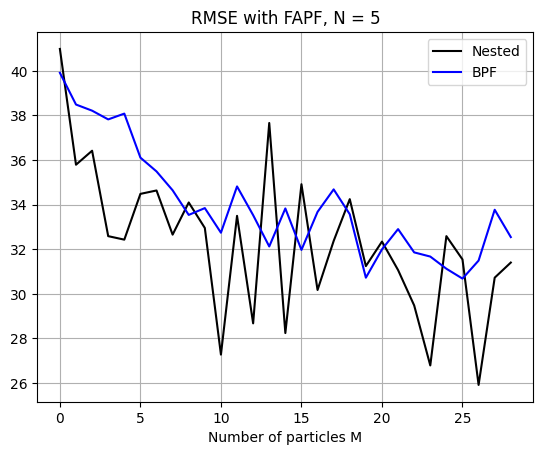

In [ ]:
N = 5
M = 30
D = 40 #dimension
A = 0.2*np.identity(D)
B = 1.1*np.identity(D)
T = 10
var_eps = np.identity(D)
var_delta = np.identity(D)
X, Y = generate(A, B, var_eps, var_delta, T, D)

nested_part_res_2 = nested_particles_2(N, M, T, D, Y, A, B, var_eps, var_delta)

In [ ]:
## increasing the number of inner particles
def nested_particles_2_(N, M_values, T, D, Y, A, B, var_eps, var_delta):
    RMSE_nested_time = []
    RMSE_bpf_time = []

    smc_part = N*M_values[-1]
    x_0 = np.array(npr.multivariate_normal(np.zeros(D), np.identity(D)))
    res_fully = fully_adapted(x_0, D, T,Y, p_ycurr_xcurr, p_ycurr_xprev, p_xcurr_xprev, q_xcurr_xprev_ycurr, q_xcurr_xprev_ycurr_init, kalman_filter_fapf_step, w_function, A, B, var_eps, var_delta, smc_part)
    estimate_fully = res_fully[2]
    
    for m in M_values:
        print(m)
        smc_part = m*N
        #run the nested smc
        res_nested = nested_smc_new(N, m, A, B, var_delta, var_eps, Y, D, T)
        nested_estimate = res_nested[1]

        #bpf
        res_bpf = bootstrap_filter_d(Y, T, A, var_eps, var_delta, D, smc_part,B)

        RMSE_res = RMSE_compare(np.array(estimate_fully), nested_estimate, np.array(res_bpf[2])) 
        
        RMSE_nested_time.append(sum(RMSE_res[0]))
        RMSE_bpf_time.append(sum(RMSE_res[1]))

    #plot
    #fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    plt.plot(M_values, RMSE_nested_time, color = 'black', label = 'Nested')
    plt.plot(M_values, RMSE_bpf_time, color = 'blue', label = 'BPF')
    plt.title(f'RMSE with FAPF, N = {N}')
    plt.xlabel('Number of particles M')
    plt.grid(True)
    plt.legend()
    return (RMSE_nested_time, RMSE_bpf_time)


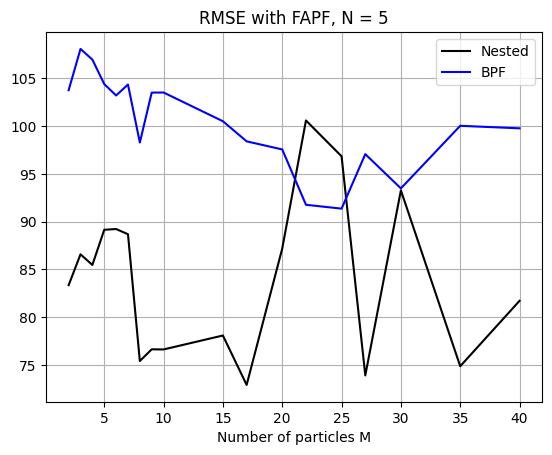

In [ ]:
N = 5
M_values = [2,3,4, 5,6,7,8,9, 10, 15, 17,20, 22, 25, 27, 30, 35, 40]
D = 100 #dimension
A = 0.2*np.identity(D)
B = 1.1*np.identity(D)
T = 10
var_eps = np.identity(D)
var_delta = np.identity(D)
X, Y = generate(A, B, var_eps, var_delta, T, D)

nested_part_res_2_ = nested_particles_2_(N, M_values, T, D, Y, A, B, var_eps, var_delta)

to_plot_nested = nested_part_res_2_[0]
to_plot_bpf = nested_part_res_2_[1]

plt.plot(np.array(M_values), to_plot_nested, color = 'black', label = 'Nested')
plt.plot(np.array(M_values), to_plot_bpf, color = 'blue', label = 'BPF')
plt.title(f'RMSE with FAPF, N = {N}')
plt.xlabel('Number of particles M')
plt.grid(True)
plt.legend()

#### Nested vs BPF

In [ ]:
def nested_D_M_val(N, M_values, T, D_values, a, b, var_eps_, var_delta_):
    RMSE_plot = np.empty((len(D_values), len(M_values)))
    for i in range (len(D_values)) :
        D = D_values[i]
        print(D)
        A = a*np.identity(D)
        B = b*np.identity(D)
        var_eps = var_eps_*np.identity(D)
        var_delta = var_delta_*np.identity(D)
        X, Y = generate(A, B, var_eps, var_delta, T, D)
        mu_x = np.array([npr.normal(0,1) for i in range (D)])
        kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)

        for k in range (len(M_values)) :
            print(M_values[k])
            res_boot = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D,N*M_values[k],B)
            res = nested_smc_new(N, M_values[k],A,B,var_delta,var_eps, Y, D, T)

            interm = RMSE_compare(kalman_res[0], res_boot[2], res[1])
            RMSE_plot[i][k] = np.mean(np.array(interm[0])) - np.mean(np.array(interm[1]))
    
    # Create a meshgrid for A and B values
    D_values_grid, M_values_grid = np.meshgrid(D_values, M_values)

    return (D_values_grid, M_values_grid, np.array(RMSE_plot))

Text(10, 10, 'BPF better than Nested')

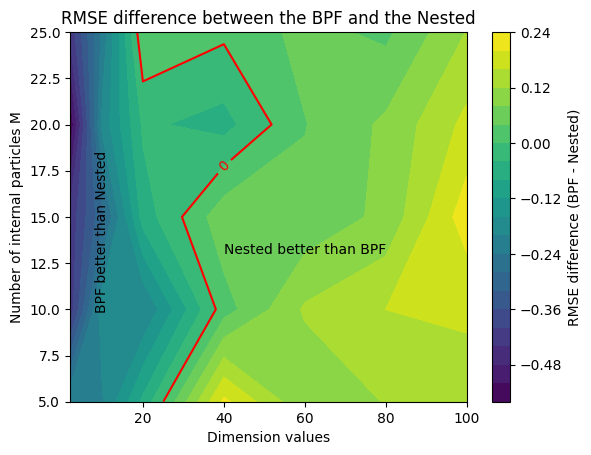

In [ ]:
D_values = [2, 10, 20, 40, 60, 80, 100]
M_values = [5, 10, 15, 20, 25]

T = 10
N = 5
a = 0.2
b = 1.1
var_eps_ = 1
var_delta_ = 1

res_nested_D_test = nested_D_M_val(N, M_values, T, D_values, a, b, var_eps_, var_delta_)


plt.figure()
contour = plt.contourf(res_nested_D_test[0], res_nested_D_test[1], res_nested_D_test[2].transpose(), levels=20, cmap='viridis')
plt.colorbar(label='RMSE difference (BPF - Nested)')
plt.xlabel('Dimension values')
plt.ylabel('Number of internal particles M')
plt.title('RMSE difference between the BPF and the Nested')


contour_curve = plt.contour(res_nested_D_test[0], res_nested_D_test[1], res_nested_D_test[2].transpose(), levels=[0], colors='red')
plt.clabel(contour_curve, fmt='0', inline=True, fontsize=10, colors='red')

plt.text(60, 13, 'Nested better than BPF', fontsize=10, ha='center')
plt.text(10, 10, 'BPF better than Nested', fontsize=10, ha='center', rotation = 90)

#250 min to run

#### Dependence on parameters a and b

In [ ]:
def RMSE_3d_nested_a_b(a_values, b_values, var_eps, var_delta, T, N, D, M):
    RMSE_plot = np.empty((len(a_values), len(b_values)))
    for i in range (len(a_values)) :
        print(a_values[i])
        for k in range (len(b_values)):
          print(b_values[k])
          A = a_values[i]*np.identity(D)
          B = b_values[k]*np.identity(D)
          X, Y = generate(A, B, var_eps, var_delta, T, D)

          mu_x = np.array([npr.normal(0,1) for i in range (D)])
          kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)

          res_boot = bootstrap_filter_d(Y,T,A,var_eps,var_delta,D,N*M,B)
          res = nested_smc_new(N, M,A,B,var_delta,var_eps, Y, D, T)

          interm = RMSE_compare(kalman_res[0], res_boot[2], res[1])
          RMSE_plot[i][k] = np.mean(np.array(interm[0])) - np.mean(np.array(interm[1]))

    # Create a meshgrid for A and B values
    A_grid, B_grid = np.meshgrid(a_values, b_values)

    return (A_grid, B_grid, np.array(RMSE_plot))



0.1
0.1
0.325
0.55
0.775
1.0
0.325
0.1
0.325
0.55
0.775
1.0
0.55
0.1
0.325
0.55
0.775
1.0
0.775
0.1
0.325
0.55
0.775
1.0
1.0
0.1
0.325
0.55
0.775
1.0


<a list of 0 text.Text objects>

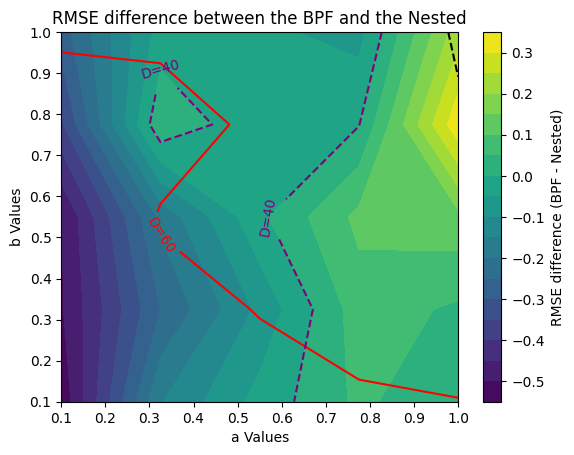

In [ ]:
D = 10
n_points = 5
a_values = np.linspace(0.1, 1, n_points)
b_values = np.linspace(0.1, 1, n_points)
var_eps = np.identity(D)
var_delta = np.identity(D)
T = 10
N = 5
M = 5

D_10_res = RMSE_3d_nested_a_b(a_values, b_values, var_eps, var_delta, T, N, D, M)

D = 40
a_values = np.linspace(0.1, 1, n_points)
b_values = np.linspace(0.1, 1, n_points)
var_eps = np.identity(D)
var_delta = np.identity(D)


D_40_res = RMSE_3d_nested_a_b(a_values, b_values, var_eps, var_delta, T, N, D, M)



D = 60
a_values = np.linspace(0.1, 1, n_points)
b_values = np.linspace(0.1, 1, n_points)
var_eps = np.identity(D)
var_delta = np.identity(D)


D_60_res = RMSE_3d_nested_a_b(a_values, b_values, var_eps, var_delta, T, N, D, M)

plt.figure()
contour = plt.contourf(D_60_res[0], D_60_res[1], D_60_res[2], levels=20, cmap='viridis')
contour = plt.contourf(D_40_res[0], D_40_res[1], D_40_res[2], levels=20, cmap='viridis')
plt.colorbar(label='RMSE difference (BPF - Nested)')
plt.xlabel('a Values')
plt.ylabel('b Values')
plt.title('RMSE difference between the BPF and the Nested')


contour_curve = plt.contour(D_60_res[0], D_60_res[1], D_60_res[2], levels=[0], colors='red')
plt.clabel(contour_curve, fmt='D=60', inline=True, fontsize=10, colors='red')
contour_curve = plt.contour(D_40_res[0], D_40_res[1], D_40_res[2], levels=[0], colors='purple', linestyles = 'dashed')
plt.clabel(contour_curve, fmt='D=40', inline=True, fontsize=10, colors='purple')
contour_curve = plt.contour(D_10_res[0], D_10_res[1], D_10_res[2], levels=[0], colors='black', linestyles = 'dashed')
plt.clabel(contour_curve, fmt='D=20', inline=True, fontsize=10, colors='black')

#### Nested vs DAC

In [ ]:
def nested_D_M_dac(N, M_values, T, D_values, a, b, var_eps_, var_delta_):
    RMSE_plot = np.empty((len(M_values), len(D_values)))
    for i in range (len(D_values)) :
        D = D_values[i]
        print(D)
        A = a*np.identity(D)
        B = b*np.identity(D)
        var_eps = var_eps_*np.identity(D)
        var_delta = var_delta_*np.identity(D)
        X, Y = generate(A, B, var_eps, var_delta, T, D)
        mu_x = np.array([npr.normal(0,1) for i in range (D)])
        kalman_res = kalman_filter_d(A, B, var_eps, var_delta, Y, T, mu_x)

        for k in range (len(M_values)) :
            res_dac = dac_procedure_all(Y, A, B, var_eps, var_delta, N*M_values[k])
            res = nested_smc_new(N, M_values[k],A,B,var_delta,var_eps, Y, D, T)

            interm = RMSE_compare(kalman_res[0], res_dac[2], res[1])
            RMSE_plot[i][k] = np.mean(np.array(interm[0])) - np.mean(np.array(interm[1]))
    
    # Create a meshgrid for A and B values
    D_values_grid, M_values_grid = np.meshgrid(D_values, M_values)

    return (D_values_grid, M_values_grid, np.array(RMSE_plot))


Text(0.5, 1.0, 'RMSE difference between the DAC and the Nested')

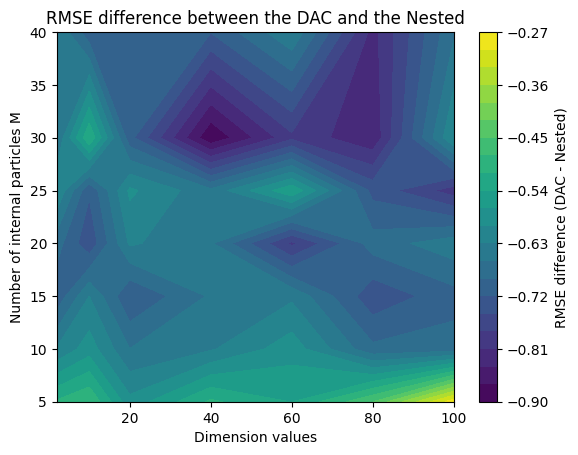

In [ ]:
D_values = [2, 10, 20, 40, 60, 80, 100]
M_values = [5, 10, 15, 20, 25, 30, 40]
T = 10
N = 5
a = 0.2
b = 1.1
var_eps_ = 1
var_delta_ = 1

res_nested_dac_D = nested_D_M_dac(N, M_values, T, D_values, a, b, var_eps_, var_delta_)


plt.figure()
contour = plt.contourf(res_nested_dac_D[0], res_nested_dac_D[1], res_nested_dac_D[2], levels=20, cmap='viridis')
plt.colorbar(label='RMSE difference (DAC - Nested)')
plt.xlabel('Dimension values')
plt.ylabel('Number of internal particles M')
plt.title('RMSE difference between the DAC and the Nested')



#480 min to run

# Main results for the Lorenz model

## Visualize

In [63]:
# generate X and Y 
F = 8.0
D = 15
T = 10
H = np.identity(D)
noise_strength_x = 0.1 # Adjust the noise strength as needed
noise_strength_y = 1
dt = 0.01  # Time step for integration

x = generate_lorenz_with_transition_noise(F, D, T, noise_strength_x, dt)
indices = [int(i/dt) for i in range(T)]
x_ = x[indices]
y = np.empty(np.shape(x_))
for i in range (len(x_)):
    y[i] = np.dot(H,x_[i]) + npr.normal(0, noise_strength_y, D)   


In [64]:
# BPF
res_bpf = bpf_lorenz_x_y(y, noise_strength_x, noise_strength_y, 100, F, D, T, H, dt)

In [65]:
# FAPF
x_0 = npr.normal(F,noise_strength_x)
Q = noise_strength_x*np.identity(D)
R = noise_strength_y*np.identity(D)
res_fapf = fapf_lorenz(x_0, y, Q, R, 100, D, T,H,dt,F,noise_strength_x)

C:\Users\candi\AppData\Local\Temp\ipykernel_6916\3196188780.py:6: RuntimeWarning: overflow encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_6916\3196188780.py:6: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_6916\3218453042.py:12: RuntimeWarning: invalid value encountered in add
  x[i] = x[i - 1] + dX + dW


In [66]:
# EKF
initial_state = npr.normal(8, 0.01,D)
res_kalman = ekf_lorenz_0(initial_state, y, dt, T, noise_strength_x, noise_strength_y, F, D, generate_full_jacobian)

In [67]:
# DAC
res_dac = dac_procedure_lorenz(y,100, F, H, noise_strength_x, noise_strength_y,dt, D, T)

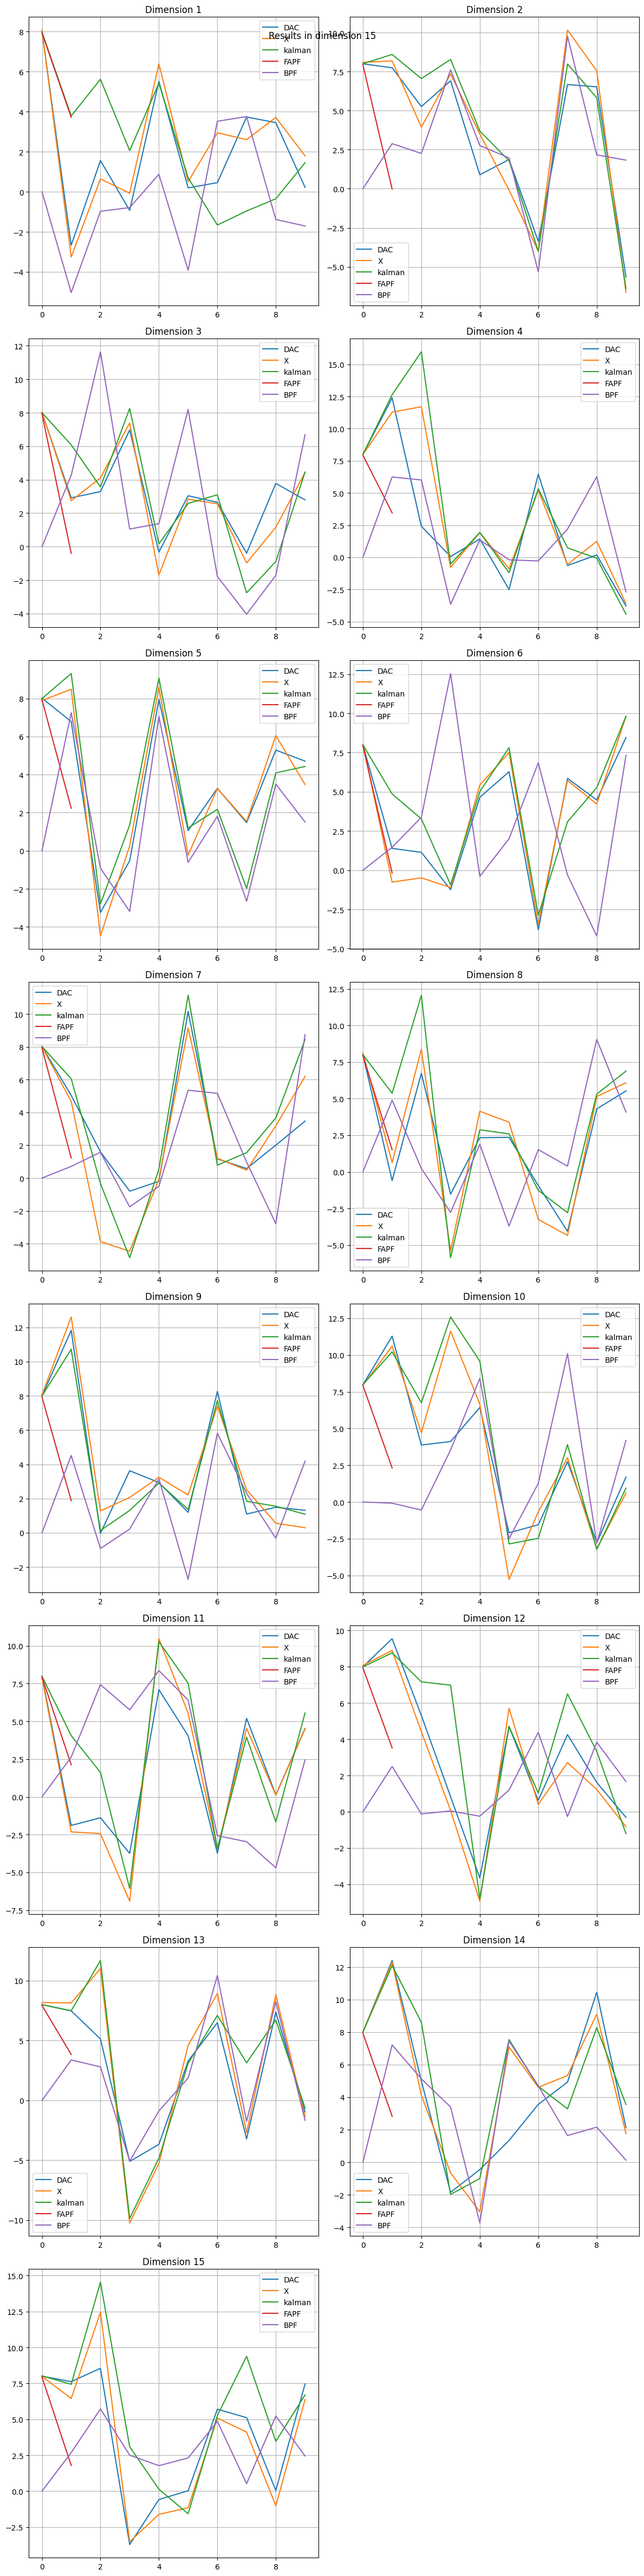

In [68]:
plot_multiple_graphs([res_dac[2].transpose(), x_.transpose(), np.array(res_kalman[0]).transpose(), np.array(res_fapf[2]).transpose(), np.array(res_bpf[2]).transpose()], ['DAC', 'X', 'kalman', 'FAPF', 'BPF'])

## Visualize distributions

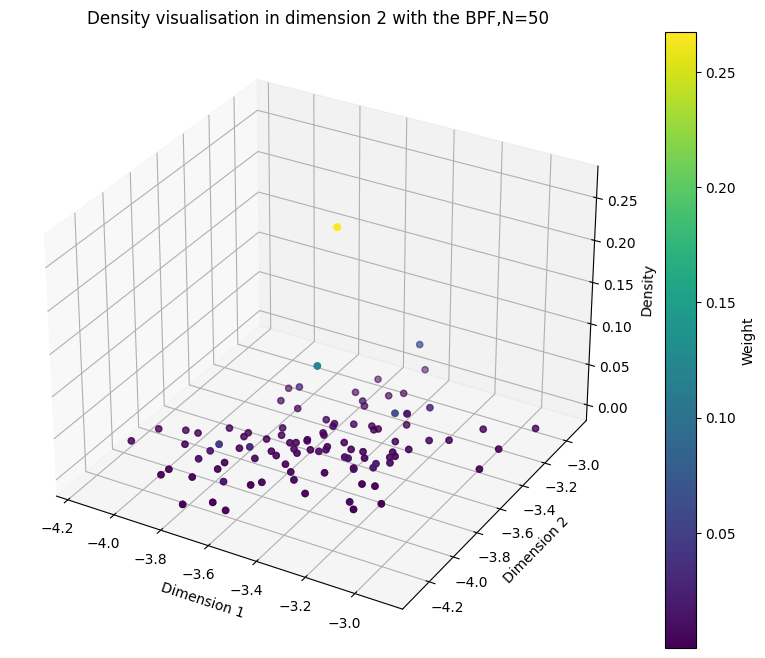

In [ ]:
#visualize distributions 
t = 2
particles = res_bpf[0]
weights = res_bpf[1]


# Create a 3D meshgrid
d0 = 30
d1 = 38
x = particles[t][d0]
y = particles[t][d1]
z = weights[t]

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

cbar = plt.colorbar(ax.scatter(x, y, z, c=z, cmap='viridis', marker='o'))
cbar.set_label('Weight')

# Set labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Density')
ax.set_title(f'Density visualisation in dimension 2 with the BPF,N={50}')

# Display the plot
plt.show()


## DAC vs BPF vs FAPF vs EKF until N = 1000

In [119]:
# generate X and Y 
F = 8.0
D = 15
T = 10
H = np.identity(D)
noise_strength_x = 0.1 # Adjust the noise strength as needed
noise_strength_y = 1
dt = 0.01  # Time step for integration

x = generate_lorenz_with_transition_noise(F, D, T, noise_strength_x, dt)
indices = [int(i/dt) for i in range(T)]
x_ = x[indices]
y = np.empty(np.shape(x_))
for i in range (len(x_)):
    y[i] = np.dot(H,x_[i]) + npr.normal(0, noise_strength_y, D)   


Q = noise_strength_x*np.identity(D)
R = noise_strength_y*np.identity(D)

In [120]:
N_values_ = np.array([10*i for i in range (2, 100)])   

In [128]:
# EKF
initial_state = npr.normal(8, 0.01,D)
res_kalman = ekf_lorenz_0(initial_state, y, dt, T, noise_strength_x, noise_strength_y, F, D, generate_full_jacobian)[0]

RMSE_ekf = np.mean(RMSE_by_coordinate(np.array(res_kalman).transpose(), np.array(x_).transpose()))*np.ones(len(N_values_))

In [129]:
# BPF
RMSE_bpf_new = []
for n in (N_values_):
    res_bpf = bpf_lorenz_x_y(y, noise_strength_x, noise_strength_y, n, F, D, T, H, dt)[2]
    RMSE_bpf_new.append(np.mean(RMSE_by_coordinate(np.array(res_bpf).transpose(), np.array(x_).transpose())))

In [140]:
# DAC
RMSE_dac_new = []
for n in (N_values_):
    print(n)
    res_dac = dac_procedure_lorenz(y,n, F, H, noise_strength_x, noise_strength_y,dt, D, T)[2]
    RMSE_dac_new.append(np.mean(RMSE_by_coordinate(np.array(res_dac).transpose(), np.array(x_).transpose())))

20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [66]:
RMSE_fapf_new = []
x_0 = npr.normal(F,0.01)
for n in (N_values_):
    print(n)
    res_fapf = fapf_lorenz(x_0, y, Q, R, n, D, T, H, dt, F, noise_strength_x)[2]
    RMSE_fapf_new.append(np.mean(RMSE_by_coordinate(np.array(res_fapf).transpose(), np.array(x_).transpose())))

20
30
40
50
60
70
80
90
100
110
120
130
140
150


C:\Users\candi\AppData\Local\Temp\ipykernel_3992\3196188780.py:6: RuntimeWarning: overflow encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_3992\3196188780.py:6: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_3992\3218453042.py:12: RuntimeWarning: invalid value encountered in add
  x[i] = x[i - 1] + dX + dW


160
170
180
190


c:\Users\candi\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_multivariate.py:489: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(np.dot(dev, prec_U)), axis=-1)


200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


In [73]:
RMSE_fapf_new_ = []
for i in range (len(RMSE_fapf_new)):
    if np.isnan(RMSE_fapf_new[i]) == True:
        RMSE_fapf_new_.append(RMSE_fapf_new[i-1])
    else :
        RMSE_fapf_new_.append(RMSE_fapf_new[i])

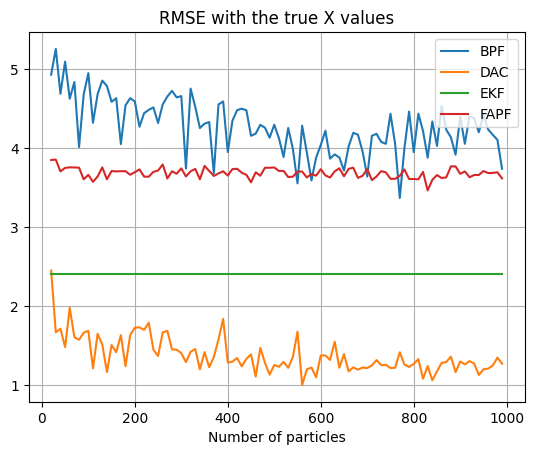

In [74]:
plt.plot(N_values_, RMSE_bpf_new, label = 'BPF')
plt.plot(N_values_, RMSE_dac_new, label = 'DAC')
plt.plot(N_values_, RMSE_ekf, label = 'EKF')
plt.plot(N_values_, RMSE_fapf_new_, label = 'FAPF')
plt.grid(True)
plt.title('RMSE with the true X values')
plt.xlabel('Number of particles')
plt.legend()
plt.show()


### Individual graphs

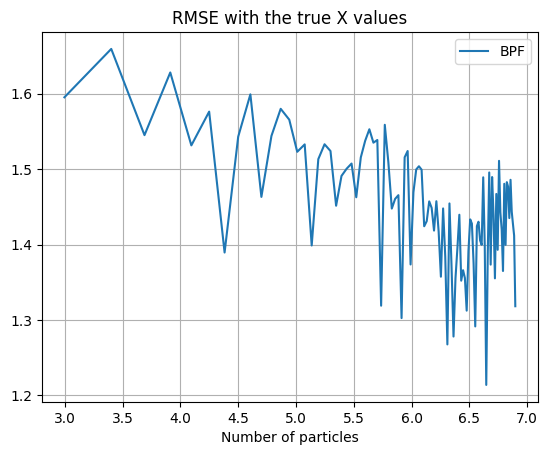

In [79]:
plt.plot(np.log(N_values_), np.log(RMSE_bpf_new), label = 'BPF')
plt.grid(True)
plt.title('RMSE with the true X values')
plt.xlabel('Number of particles')
plt.legend()
plt.show()


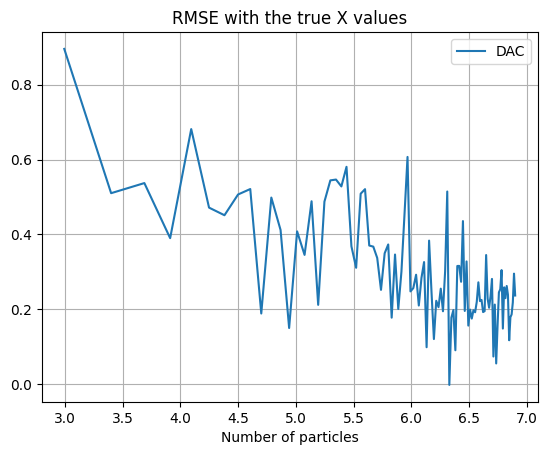

In [78]:
plt.plot(np.log(N_values_), np.log(RMSE_dac_new), label = 'DAC')
plt.grid(True)
plt.title('RMSE with the true X values')
plt.xlabel('Number of particles')
plt.legend()
plt.show()


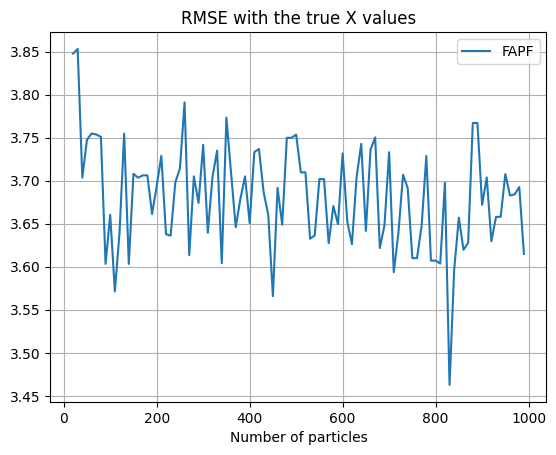

In [77]:
plt.plot(N_values_, RMSE_fapf_new_, label = 'FAPF')
plt.grid(True)
plt.title('RMSE with the true X values')
plt.xlabel('Number of particles')
plt.legend()
plt.show()


### Zoom for N until 150

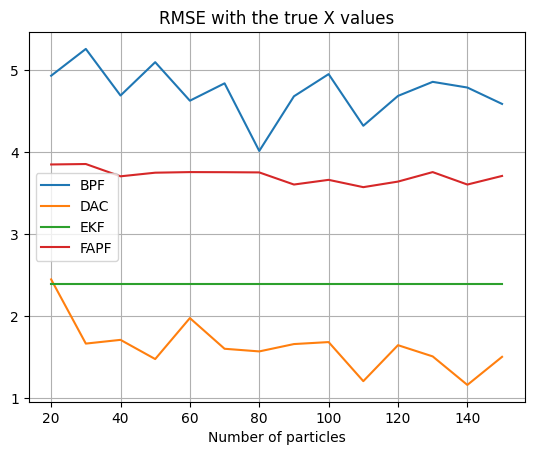

In [87]:
plt.plot(N_values_[0:14], RMSE_bpf_new[0:14], label = 'BPF')
plt.plot(N_values_[0:14], RMSE_dac_new[0:14], label = 'DAC')
plt.plot(N_values_[0:14], RMSE_ekf[0:14], label = 'EKF')
plt.plot(N_values_[0:14], RMSE_fapf_new_[0:14], label = 'FAPF')
plt.grid(True)
plt.title('RMSE with the true X values')
plt.xlabel('Number of particles')
plt.legend()
plt.show()


## Convergence of the algorithms to the EKF

In [ ]:
# generate X and Y 
F = 8.0
D = 40
T = 30
H = np.identity(D)
noise_strength_x = 0.01 # Adjust the noise strength as needed
noise_strength_y = 2
dt = 0.01  # Time step for integration

x = generate_lorenz_with_transition_noise(F, D, T, noise_strength_x, dt) # on génère déjà avec du noise au départ
indices = [int(i/dt) for i in range(T)]
x_ = x[indices]
y = np.empty(np.shape(x_))
for i in range (len(x_)):
    y[i] = np.dot(H,x_[i]) + npr.normal(0, noise_strength_y, D)

### Convergence BPF to EKF

In [ ]:
def convergence_kalman_bpf_lorenz_0(Y, noise_strength_x, noise_strength_y, N, F, D, T, H, dt):
    RMSE_res = []
    RMSE_interm = []
    initial_state = npr.normal(8, 0.01,D)
    kalman_res = ekf_lorenz_0(initial_state, Y, dt, T, noise_strength_x, noise_strength_y, F, D, generate_full_jacobian)[0]
    
    for n in range (1,N):
        for k in range (10):
            res_bpf = bpf_lorenz_x_y(Y, noise_strength_x, noise_strength_y, n, F, D, T, H, dt)[2]
            RMSE_interm.append(np.mean(RMSE_by_coordinate(np.array(res_bpf).transpose(), np.array(kalman_res).transpose())))
        RMSE_res.append(np.mean(RMSE_interm))
        RMSE_interm = []
        
    absciss = [i for i in range (1,N)]
    plt.plot(np.log(absciss), np.log(RMSE_res), label = 'Average RMSE of the BPF with the EKF')
    plt.grid(True)
    plt.title('Convergence of the BPF to the EKF')
    plt.xlabel('Number of particles')
    plt.legend()
    plt.show()


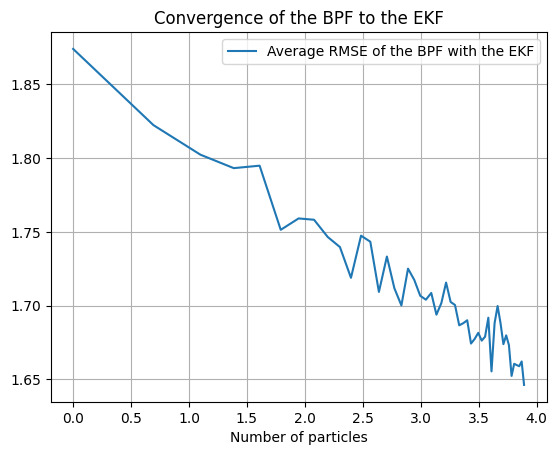

In [ ]:
# generate X and Y 
F = 8.0
D = 15
T = 20
H = np.identity(D)
noise_strength_x = 0.1 # Adjust the noise strength as needed
noise_strength_y = 2
dt = 0.01  # Time step for integration

x = generate_lorenz_with_transition_noise(F, D, T, noise_strength_x, dt) 
indices = [int(i/dt) for i in range(T)]
x_ = x[indices]
y = np.empty(np.shape(x_))
for i in range (len(x_)):
    y[i] = np.dot(H,x_[i]) + npr.normal(0, noise_strength_y, D)

convergence_kalman_bpf_lorenz_0(y, noise_strength_x, noise_strength_y, 50, F, D, T, H, dt)

### Convergence FAPF vs BPF, to EKF

In [ ]:
F = 8.0
D = 15
T = 10
H = np.identity(D)
noise_strength_x = 0.01 # Adjust the noise strength as needed
noise_strength_y = 2
dt = 0.01  # Time step for integration

x = generate_lorenz_with_transition_noise(F, D, T, noise_strength_x, dt) # on génère déjà avec du noise au départ
indices = [int(i/dt) for i in range(T)]
x_ = x[indices]
y = np.empty(np.shape(x_))
for i in range (len(x_)):
    y[i] = np.dot(H,x_[i]) + npr.normal(0, noise_strength_y, D)

Q = noise_strength_x*np.identity(D)
R = noise_strength_y*np.identity(D)

#N = 50

In [ ]:
def convergence_kalman_bpf_fapf_lorenz_0(Y, noise_strength_x, noise_strength_y, N_values, F, D, T, H, dt):
    RMSE_bpf = []
    RMSE_fapf = []
    RMSE_interm = []
    RMSE_interm_ = []

    #kalman
    initial_state = npr.normal(8, 0.01,D)
    kalman_res = ekf_lorenz_0(initial_state, Y, dt, T, noise_strength_x, noise_strength_y, F, D, generate_full_jacobian)[0]
    
    for n in (N_values):
        #print('n',n)
        for k in range (2):
            res_bpf = bpf_lorenz_x_y(Y, noise_strength_x, noise_strength_y, n, F, D, T, H, dt)[2]
            RMSE_interm.append(np.nanmean(RMSE_by_coordinate(np.array(res_bpf).transpose(), np.array(kalman_res).transpose())))
            x_0 = npr.normal(F,noise_strength_x)
            res_fapf = fapf_lorenz(x_0, Y, Q, R, n, D, T, H, dt, F, noise_strength_x)
            RMSE_interm_.append(np.nanmean(RMSE_by_coordinate(np.array(res_fapf[2]).transpose(), np.array(kalman_res).transpose())))
        #res_bpf = bpf_lorenz_x_y(Y, noise_strength_x, noise_strength_y, n, F, D, T, H, dt)[2]
        #RMSE_bpf.append(np.nanmean(RMSE_by_coordinate(np.array(res_bpf).transpose(), np.array(kalman_res).transpose())))
        #x_0 = npr.normal(F,noise_strength_x)
        #res_fapf = fapf_lorenz(x_0, Y, Q, R, n, D, T, H, dt, F, noise_strength_x)[2]
        #RMSE_fapf.append(np.nanmean(RMSE_by_coordinate(np.array(res_fapf).transpose(), np.array(kalman_res).transpose())))

        RMSE_bpf.append(np.nanmean(RMSE_interm))
        RMSE_fapf.append(np.nanmean(RMSE_interm_))
        RMSE_interm = []
        RMSE_interm_ = []
        
    absciss = [i for i in (N_values)]
    plt.plot(np.log(absciss), np.log(RMSE_bpf), label = 'RMSE of the BPF with the EKF')
    plt.plot(np.log(absciss), np.log(RMSE_fapf), label = 'RMSE of the FAPF with the EKF')
    plt.grid(True)
    plt.title('Convergence to the EKF')
    plt.xlabel('Number of particles')
    plt.legend()
    plt.show()

    return (RMSE_bpf, RMSE_fapf)


C:\Users\candi\AppData\Local\Temp\ipykernel_6836\3196188780.py:6: RuntimeWarning: overflow encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_6836\3196188780.py:6: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_6836\3218453042.py:12: RuntimeWarning: invalid value encountered in add
  x[i] = x[i - 1] + dX + dW


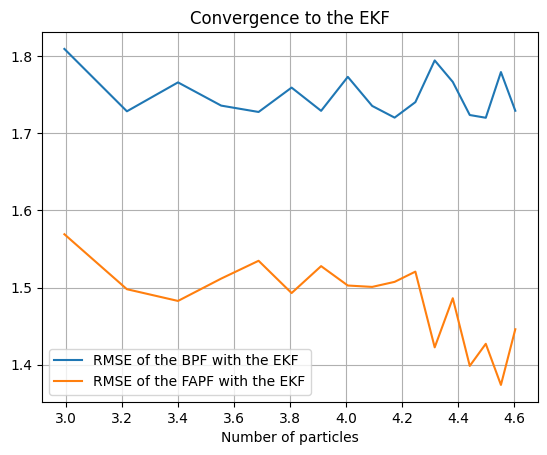

In [ ]:
N_values = np.array([20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])
#N_values = np.array([i for i in range (20, 100)])
conv_3 = convergence_kalman_bpf_fapf_lorenz_0(y, noise_strength_x, noise_strength_y, N_values, F, D, T, H, dt)

Text(0.5, 1.0, 'Convergence of the FAPF with the EKF')

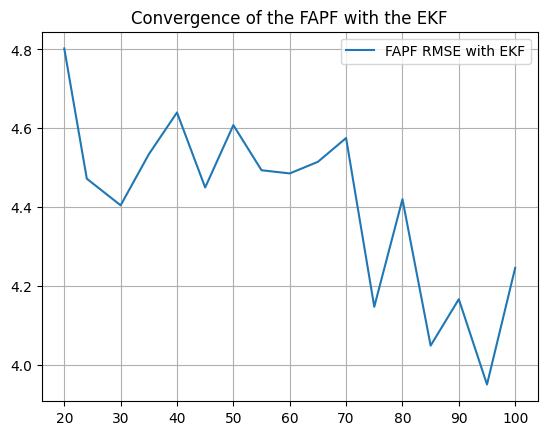

In [ ]:
plt.plot([i for i in N_values], conv_3[1], label = 'FAPF RMSE with EKF')
plt.grid(True)
plt.legend()
plt.title('Convergence of the FAPF with the EKF')

### DAC convergence to EKF

In [ ]:
def kalman_dac_conv(Y, noise_strength_x, noise_strength_y, N_values, F, D, T, H, dt):
    RMSE_dac = []

    initial_state = npr.normal(8, 0.01,D)
    kalman_res = ekf_lorenz_0(initial_state, Y, dt, T, noise_strength_x, noise_strength_y, F, D, generate_full_jacobian)[0]
    
    for n in (N_values):
        print('n',n)
        res_dac = dac_procedure_lorenz(Y,n, F, H, noise_strength_x, noise_strength_y,dt, D, T)[2]
        RMSE_dac.append(np.mean(RMSE_by_coordinate(np.array(res_dac).transpose(), np.array(kalman_res).transpose())))
        
    absciss = [i for i in (N_values)]
    #plt.plot(np.log(absciss), np.log(RMSE_bpf), label = 'RMSE of the BPF with the EKF')
    plt.plot(np.log(absciss), np.log(RMSE_dac), label = 'RMSE of the DAC with the EKF')
    plt.grid(True)
    plt.title('Convergence to the EKF')
    plt.xlabel('Number of particles')
    plt.legend()
    plt.show()

    return(RMSE_dac)

In [ ]:
# generate X and Y 
F = 8.0
D = 15
T = 10
H = np.identity(D)
noise_strength_x = 0.1 # Adjust the noise strength as needed
noise_strength_y = 1
dt = 0.01  # Time step for integration

x = generate_lorenz_with_transition_noise(F, D, T, noise_strength_x, dt) 
indices = [int(i/dt) for i in range(T)]
x_ = x[indices]
y = np.empty(np.shape(x_))
for i in range (len(x_)):
    y[i] = np.dot(H,x_[i]) + npr.normal(0, noise_strength_y, D)   


n 20
n 30
n 40
n 50
n 60
n 70
n 80
n 90
n 100


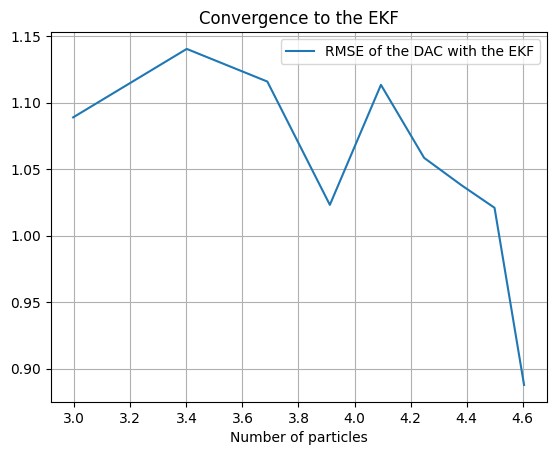

In [ ]:
N_values = np.array([20, 30, 40, 50, 60, 70, 80, 90, 100])
conv = kalman_dac_conv(y, noise_strength_x, noise_strength_y, N_values, F, D, T, H, dt)

In [ ]:
# generate X and Y 
F = 8.0
D = 15
T = 10
H = np.identity(D)
noise_strength_x = 0.1 # Adjust the noise strength as needed
noise_strength_y = 1
dt = 0.01  # Time step for integration

x = generate_lorenz_with_transition_noise(F, D, T, noise_strength_x, dt)
indices = [int(i/dt) for i in range(T)]
x_ = x[indices]
y = np.empty(np.shape(x_))
for i in range (len(x_)):
    y[i] = np.dot(H,x_[i]) + npr.normal(0, noise_strength_y, D)   


Q = noise_strength_x*np.identity(D)
R = noise_strength_y*np.identity(D)

initial_state = npr.normal(8, 0.01,D)
kalman_res = ekf_lorenz_0(initial_state, y, dt, T, noise_strength_x, noise_strength_y, F, D, generate_full_jacobian)[0]
    
N_values = np.array([20, 24, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100])   

In [ ]:
RMSE_bpf = []
for n in (N_values):
    res_bpf = bpf_lorenz_x_y(y, noise_strength_x, noise_strength_y, n, F, D, T, H, dt)[2]
    RMSE_bpf.append(np.mean(RMSE_by_coordinate(np.array(res_bpf).transpose(), np.array(kalman_res).transpose())))

In [ ]:
RMSE_dac = []
for n in (N_values):
    print(n)
    res_dac = dac_procedure_lorenz(y,n, F, H, noise_strength_x, noise_strength_y,dt, D, T)[2]
    RMSE_dac.append(np.mean(RMSE_by_coordinate(np.array(res_dac).transpose(), np.array(kalman_res).transpose())))

20
24
30
35
40
45
50
55
60
65
70
75
80
85
90
95
100


In [ ]:
RMSE_fapf = []
x_0 = npr.normal(F,0.01)
for n in (N_values):
    print(n)
    res_fapf = fapf_lorenz(x_0, y, Q, R, n, D, T, H, dt, F, noise_strength_x)[2]
    RMSE_fapf.append(np.mean(RMSE_by_coordinate(np.array(res_fapf).transpose(), np.array(kalman_res).transpose())))

20
24
30
35
40
45


C:\Users\candi\AppData\Local\Temp\ipykernel_6836\3196188780.py:6: RuntimeWarning: overflow encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_6836\3196188780.py:6: RuntimeWarning: invalid value encountered in double_scalars
  d[i] = (x[(i + 1) % D] - x[i - 2]) * x[i - 1] - x[i] + F
C:\Users\candi\AppData\Local\Temp\ipykernel_6836\3218453042.py:12: RuntimeWarning: invalid value encountered in add
  x[i] = x[i - 1] + dX + dW


50
55
60
65
70
75
80
85
90
95
100


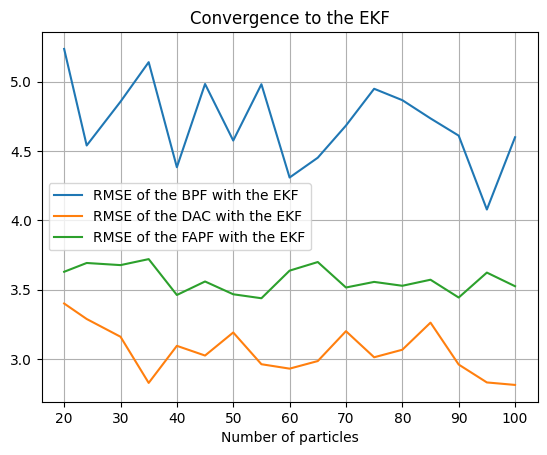

In [ ]:
absciss = [i for i in (N_values)]
plt.plot(absciss, RMSE_bpf, label = 'RMSE of the BPF with the EKF')
plt.plot(absciss, RMSE_dac, label = 'RMSE of the DAC with the EKF')
plt.plot(absciss, RMSE_fapf, label = 'RMSE of the FAPF with the EKF')
plt.grid(True)
plt.title('Convergence to the EKF')
plt.xlabel('Number of particles')
plt.legend()
plt.show()
